In [1]:
!pip install modAL
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestClassifier
from modAL.disagreement import max_std_sampling 
from modAL.disagreement import consensus_entropy
from modAL.uncertainty import uncertainty_sampling
import pandas as pd
import numpy as np
from modAL.models import ActiveLearner
from modAL.uncertainty import entropy_sampling
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [3]:
#Importing All classifiers
from sklearn.ensemble import RandomForestClassifier
from modAL.models import Committee
from modAL.expected_error import expected_error_reduction
from modAL.disagreement import KL_max_disagreement
from modAL.disagreement import max_disagreement_sampling
from modAL.disagreement import max_std_sampling 
from modAL.disagreement import consensus_entropy
from modAL.uncertainty import uncertainty_sampling
import pandas as pd
import numpy as np
from modAL.models import ActiveLearner
from modAL.uncertainty import entropy_sampling
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.interpolate import make_interp_spline
import numpy as np
#KNN WITH CV

from sklearn.model_selection import GridSearchCV

from sklearn.svm import SVC

# defining parameter range
param_grid = {'C': [0.1,100, 1000],
              'gamma': [1, 0.1,0.0001],
              'kernel': ["rbf","poly","sigmoid"]}

SVC_gscv = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)

from sklearn.linear_model import LogisticRegression

#Random Forest
from sklearn.ensemble import RandomForestClassifier

param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

RF_gscv = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, cv= 5)



#LDA and QDA

from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


from modAL.uncertainty import classifier_uncertainty

In [158]:
test_size

0.9

In [4]:
data=pd.read_csv("/home/rbcdsai/Desktop/Wholesale customers data.csv")

In [5]:
#Preprocessing of Datasets - This Code is to be replaced in accordance to the dataset used

data=pd.read_csv("/home/rbcdsai/Desktop/Wholesale customers data.csv")

cleanups_nums={"Channel":{1:0,2:1},
               }
data=data.replace(cleanups_nums)
data_f = data

columns=data_f.columns
columns=columns.drop("Region")
columns=columns.drop("Channel")



for i in columns:
     data_f.sort_values(by=[i],inplace=True)
     data_f[i]= pd.qcut(data_f[i],q = 4,labels = False,duplicates='drop')
    

data_f = data_f.sample(frac=1, random_state=42).reset_index(drop=True)
col=data_f.columns

data_f=np.array(data_f)

data_f=pd.DataFrame(data_f,columns=col)

att_end=6
y_index=7
att_start_w=0
att_end_w=6
y_index_w=7
att_mid_w1=3
att_mid_w2=4



data_f=data_f.drop_duplicates(subset=data_f.columns[0:att_end])
data_f=data_f.reset_index(drop=True)


#data_test=data_f.loc[0:250]
#data_f=data_f.loc[0:200]
col=[i for i in range(0,data_f.shape[1])]

data_f.columns=col

data_test=data_f

In [186]:
#Code to determine average similarity
X=data_f.loc[:,:att_end]
L=modAL.density.information_density(X,"euclidean")
print(np.mean(L))  

0.015422213680854155


In [6]:
#Tallying

'''Function to train Tallying heuristic'''

def tall(data_f,threshold):
    dataset=np.array(data_f)
       
    negative=list()
    positive=list()
    #wt=wt.astype(int)
    for att in range(0,len(data_f.columns)):
        for i in range(0,len(dataset)):
            if dataset[i,att]>=np.median(dataset[:,att]):
                dataset[i,y_index]=1
            else:
                dataset[i,y_index]=0
        data_tallying=pd.DataFrame(dataset,columns=data_f.columns)       
        acc1=roc_auc_score(data_f.loc[:,y_index_w],data_tallying.loc[:,y_index_w])
        for i in range(0,len(dataset)):
            if dataset[i,att]>=np.median(dataset[:,att]):
                dataset[i,y_index]=0
            else:
                dataset[i,y_index]=1
        data_tallying=pd.DataFrame(dataset,columns=data_f.columns)        
        acc2=roc_auc_score(data_f.loc[:,y_index_w],data_tallying.loc[:,y_index_w])

        if acc1>=acc2:
           if acc1>=0.6:
              positive.append(att)
              print("pos",att)
        else:
           if acc2>=0.6:
              negative.append(att)
              print("neg",att)
        
    for i in range(0,len(dataset)):
        positivevotes=0
        negativevotes=0
        for j in positive:
            if dataset[i,j]>=np.median(dataset[:,j]):
                 positivevotes=positivevotes+1
        for j in negative:
            if dataset[i,j]>=np.median(dataset[:,j]):
                  negativevotes=negativevotes+1
        if  positivevotes>=threshold:   #Threshold has been set as 3
           dataset[i,y_index]=1
        else:
           dataset[i,y_index]=0

    data_tallying=pd.DataFrame(dataset,columns=data_f.columns)
    j=0
    for i in range(0,len(data_tallying)):
        if data_tallying.loc[i,y_index_w]==data_f.loc[i,y_index_w]:
            j=j+1
    new_acc=roc_auc_score(data_f.loc[:,y_index_w],data_tallying.loc[:,y_index_w])
    return new_acc,data_tallying,positive,negative


'''Function to obtain the best threshold'''

def tall_thresh(data_f,att_end):
    old_acc=0   
    for i in range(1,att_end):
        new_acc,data_tallying,positive,negative=tall(data_f,i)
        if new_acc>old_acc:
            dataset_tallying=data_tallying
            old_acc=new_acc
            threshold=i
    return threshold,positive,negative

'''Function to make Predictions and compute the accuracy of the same'''




def tall_hypo(data_f,sure,threshold,positive,negative):
    dataset=np.array(data_f)
    
    sure1=np.array(sure)
    for i in range(0,len(sure)):
        positivevotes=0
        negativevotes=0
        for j in positive:
            if   sure1[i,j]>=np.median(dataset[:,j]):
                 positivevotes=positivevotes+1
        for j in negative:
            if  sure1[i,j]>np.median(dataset[:,j]):
                  negativevotes=negativevotes+1
        if  positivevotes>=threshold:   #Threshold has been set as 3
            sure1[i,y_index]=1
        else:
            sure1[i,y_index]=0

    

    sure1=pd.DataFrame(sure1,columns=sure.columns)
    

    new_acc=accuracy_score(sure.loc[:,y_index_w].astype(int),sure1.loc[:,y_index_w].astype(int))
    return new_acc,sure1



from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
d=data_test
threshold,positive,negative=tall_thresh(data_test,att_end)
new_acc,dataset_tallying=tall_hypo(data_test,data_test,threshold,positive,negative)
print("The acuracy of Tallying heuristic is:",new_acc)

PHASE 1(Tallying):

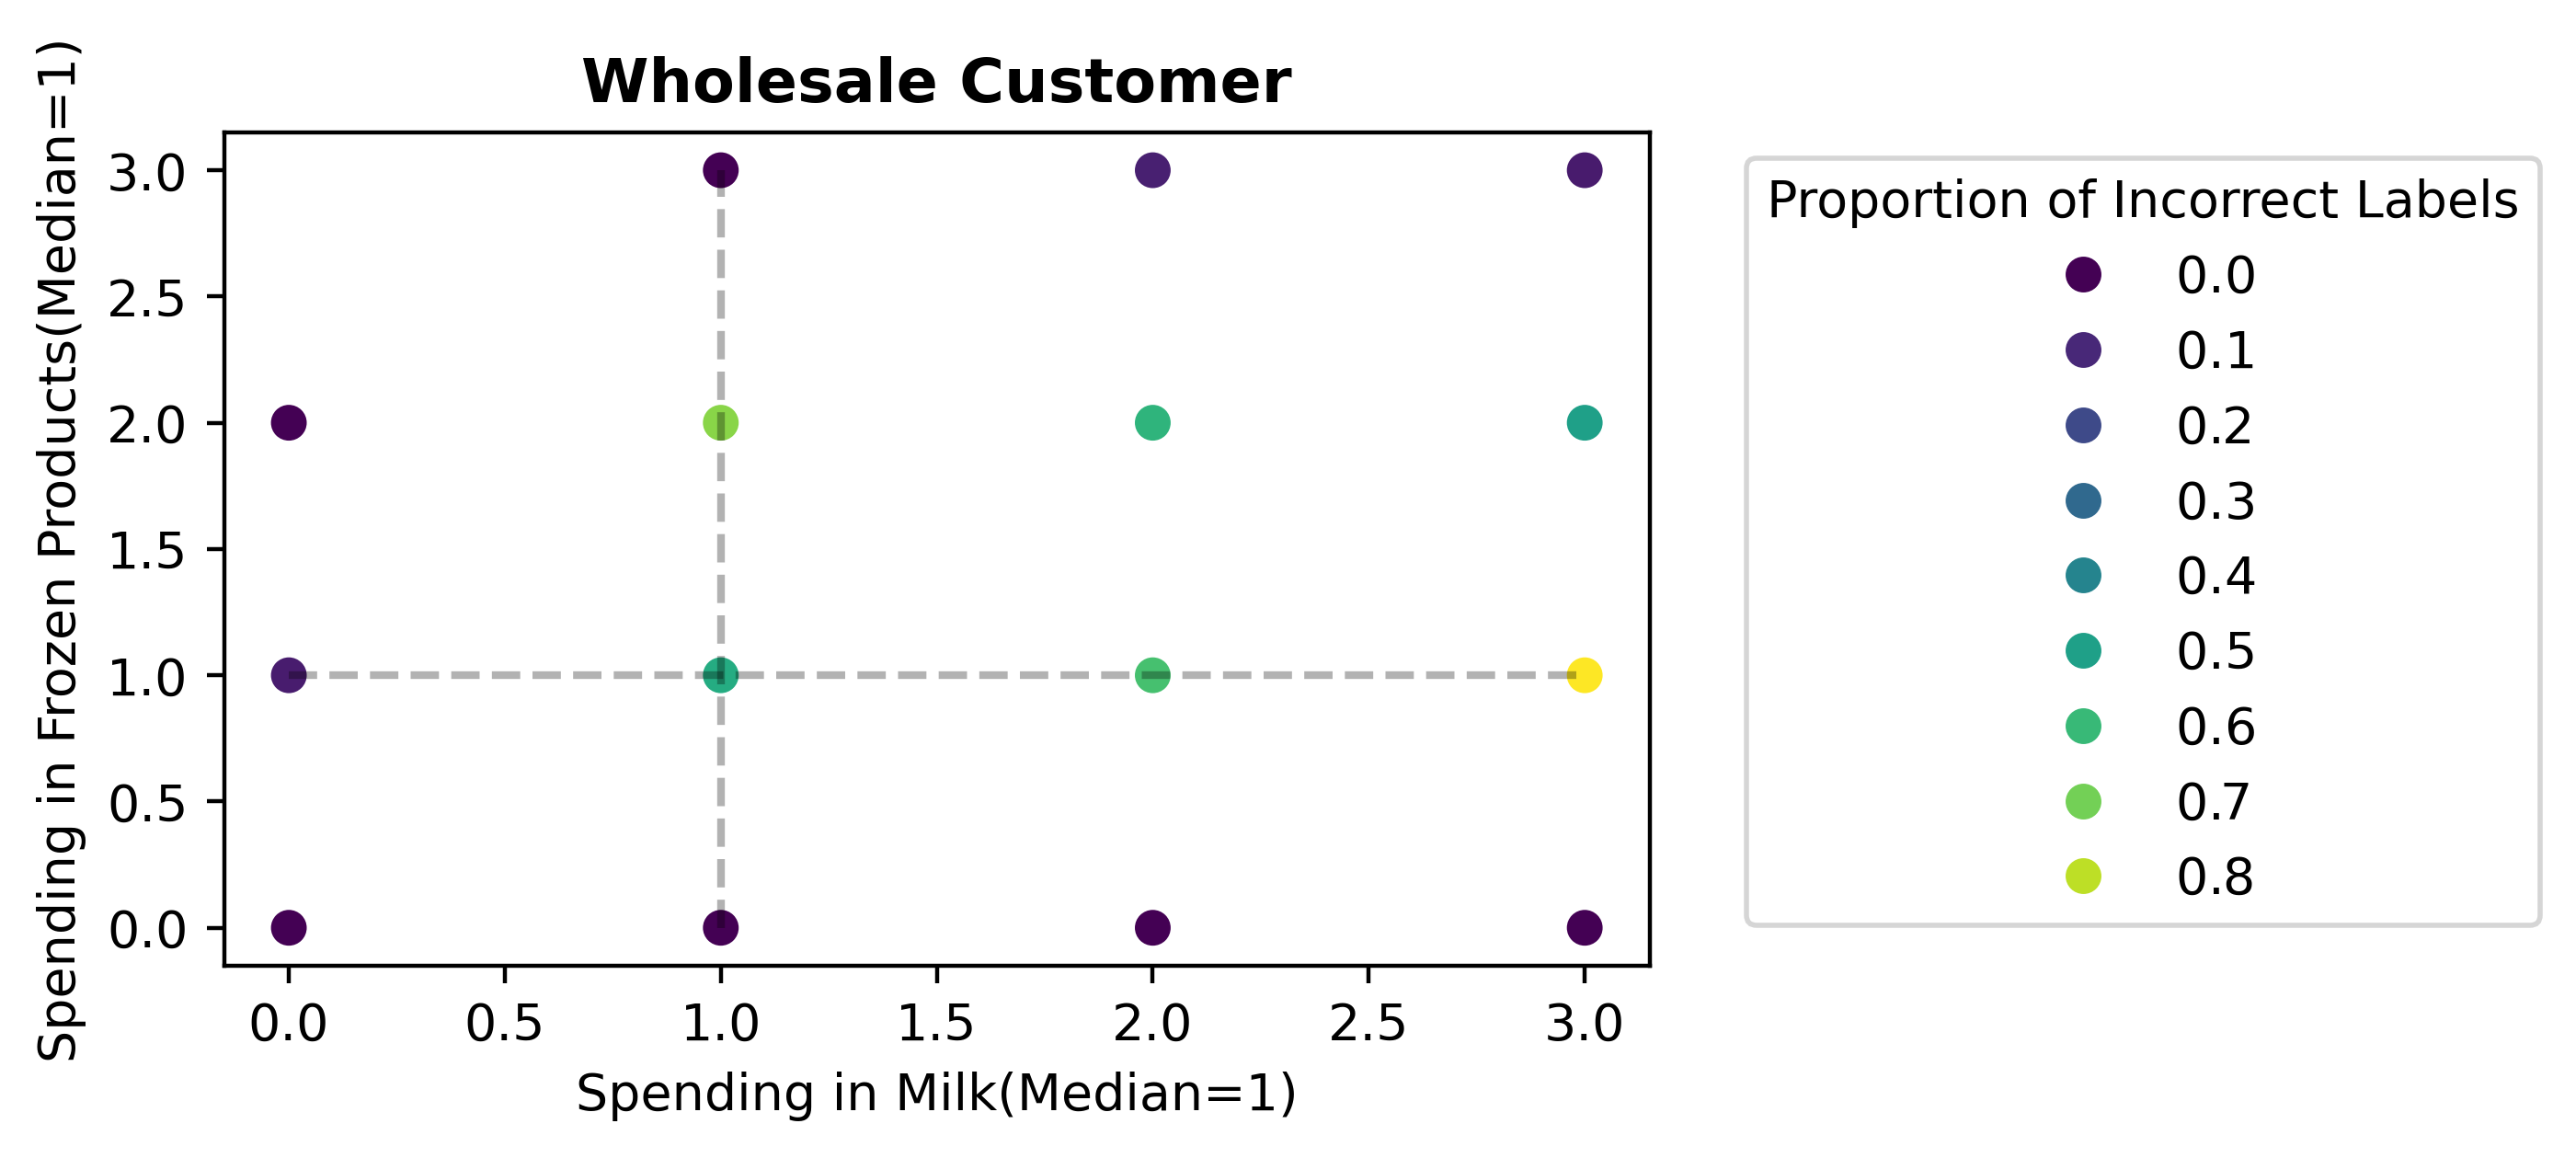

In [37]:

#Code to visualize the data-points where the prediction of Tallying heuristic is incorrect

L=pd.DataFrame()

plt.figure(figsize=(5,3), dpi=400)
for i in range(0,len(data_f)):
    if data_test.loc[i,7]==dataset_tallying.loc[i,7]:
        L=L.append([0])
    else:
        L=L.append([1])
X_vis=dataset_tallying.iloc[:,:6]
L.columns=["True/False"]
X_vis=pd.concat([X_vis,L["True/False"].reset_index(drop=True)],axis=1)
L1=X_vis.groupby([2,5], as_index=False).sum()
L2=X_vis.groupby([2,5], as_index=False).mean()
L2=L2[L1["True/False"]>1]
L1=L1[L1["True/False"]<1]

L1["True/False"]=0
L=pd.concat([L1,L2],axis=0)

#L=X_vis.groupby([1,2], as_index=False).mean()
#L=X_vis.groupby([1,2], as_index=False).mean()

scatter=plt.scatter(L[2],L[5],c=L["True/False"])

legend1 = plt.legend(*scatter.legend_elements(),bbox_to_anchor=(1.05, 1.0), loc='upper left'
                   , title="Proportion of Incorrect Labels")
#legend1.get_texts()[0].set_text('Incorrectly labeled')
#legend1.get_texts()[1].set_text('Correctly labeled') 

plt.title("Wholesale Customer",fontweight='bold')
plt.xlabel("Spending in Milk(Median=1)")
plt.ylabel("Spending in Frozen Products(Median=1)")
plt.plot([1,1],[0,3],linestyle = 'dashed',alpha=0.3,color="black")
plt.plot([0,3],[1,1],linestyle = 'dashed',alpha=0.3,color="black")

plt.show()

In [9]:
#Code for Fast and Frugal Tree

from sklearn.metrics._scorer import balanced_accuracy_score
scorer=balanced_accuracy_score

import numpy as np
import pandas as pd
import itertools
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import _scorer 
from sklearn.metrics._scorer import balanced_accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
import operator
import logging
from sklearn.metrics import recall_score

construction_algorithms = ['marginal_fan']
operator_dict = {'<=': operator.le, '>': operator.gt, '==': operator.eq, 'in': lambda val, lst: val in lst}

class FastFrugalTreeClassifier(BaseEstimator, ClassifierMixin):
    """Fast-and-Frugal-Tree classifier"""

    def __init__(self, construction_algorithm='marginal_fan',scorer=scorer, max_levels=3,
                 stopping_param=.1, max_categories=3, max_cuts=200):
        """Inits Fast-and-Frugal-Tree classifier.
        Args:
            construction_algorithm: algorithm used to create trees. Currently supported: 'marginal_fan'
            scorer: metric to maximize when choosing threshold. Any function that returns higher values for better predictions
            max_levels: maximum number of levels for possible trees
            stopping_param: prune levels containing less than stopping_param of cases
            max_categories: maximum number of categories to group together for categorical columns
            max_cuts: maximum number of cuts to try on a numerical column
        Returns:
            None
        """
        if construction_algorithm in construction_algorithms:
            self.construction_algorithm = construction_algorithm
        else:
            raise ValueError(
                'Not a valid construction_algorithm. Possible choices are {}'.format(construction_algorithms))

        self.scorer = scorer

        self.max_levels = int(max_levels)

        self.stopping_param = float(stopping_param)

        self.max_categories = max_categories

        self.max_cuts = max_cuts

    def _score(self, y, predictions):
        """Scores predictions against y.
        Args:
            y: real outcomes
            predictions: predicted outcomes
        Returns:
            Score
        """
        return self.scorer(y, predictions)

    def _get_thresholds(self, X, y):
        """Get possible thresholds and directions for each feature.
        Args:
            X: Dataframe with features as columns. Features can be numerical or categorical
            y: real, binary, outcomes.
        Returns:
            self.all_thresholds: Dataframe with rows for every feature, with threshold, direction
            and scorer
        """
        midx = pd.MultiIndex(levels=[[], []],
                             codes=[[], []],
                             names=['cue_nr', 'threshold_nr'])
        threshold_df = pd.DataFrame(columns=['feature', 'direction', 'threshold', 'type', self.scorer.__name__],
                                    index=midx)

        # Get optimal classification threshold for each feature
        for i, col in enumerate(X):
            logging.debug('Get threshold for {}'.format(col))
            j = 0

            if X[col].dtype.name == 'category':
                # categorical
                categories = X[col].cat.categories

                threshold_df['threshold'] = threshold_df['threshold'].astype(object)

                # try all possible subsets of categories

                for l in range(1, min(len(categories), self.max_categories + 1)):
                    for subset in itertools.combinations(categories, l):
                        predictions = X[col].isin(subset)
                        metric = self._score(y, predictions)

                        # save metric, direction and threshold
                        threshold_df.at[(i, j), 'direction'] = 'in'
                        threshold_df.at[(i, j), 'threshold'] = subset
                        threshold_df.at[(i, j), self.scorer.__name__] = metric
                        j += 1

                threshold_df.loc[i, 'type'] = 'categorical'
            else:
                # numerical
                #percentiles = np.linspace(0, 100, self.max_cuts + 1)
                percentiles =np.array([50])

                test_values = np.percentile(X[col], percentiles)

                # try smaller than and bigger than for every unique value in column
                for val in test_values:
                    for direction, operator in {op: operator_dict[op] for op in ['<=', '>']}.items():
                        predictions = operator(X[col], val)
                        metric = self._score(y, predictions)

                        threshold_df.at[(i, j), 'threshold'] = val
                        threshold_df.at[(i, j), 'direction'] = direction
                        threshold_df.at[(i, j), self.scorer.__name__] = metric
                        j += 1

                threshold_df.loc[i, 'type'] = 'numerical'

            threshold_df.loc[i, 'feature'] = col

        threshold_df[self.scorer.__name__] = threshold_df[self.scorer.__name__].astype(float)

        # sort features by their score
        self.all_thresholds = threshold_df

    def _get_best_thresholds(self):
        """Get thresholds and directions that maximimize scorer for each feature.
        Args:
        Returns:
            self.thresholds: Dataframe with rows for every feature, with threshold, direction
            and scorer, sorted by scorer
        """
        threshold_df = pd.DataFrame(columns=['feature', 'direction', 'threshold', 'type', self.scorer.__name__])
        for cue_nr, cue_df in self.all_thresholds.groupby(level=0):
            idx = cue_df[self.scorer.__name__].idxmax()
            threshold_df.loc[cue_nr, ['feature', 'direction', 'threshold', 'type', self.scorer.__name__]] = cue_df.loc[
                idx]

        threshold_df[self.scorer.__name__] = threshold_df[self.scorer.__name__].astype(float)

        self.thresholds = threshold_df.sort_values(by=self.scorer.__name__, ascending=False).reset_index(drop=True)

    @staticmethod
    def _predict_all(X, cue_df):
        """Make predictions for X given cue_df.
        Args:
            X: Dataframe with features as columns
            cue_df: Dataframe with ordered features, directions, thresholds, exits
        Returns:
            Series with prediction for every cue in cue_df up to the point the fast-and-frugal-tree was exited
        """
        nr_rows = cue_df.shape[0]

        # could be replaced with logical expression which would not have to be applied row-wise? currently very slow
        def _set_value(self, index, col, value, takeable=False):
           try:
            if takeable is True:
                series = self._iget_item_cache(col)
                return series._set_value(index, value, takeable=True)

            series = self._get_item_cache(col)
            engine = self.index._engine
            engine.set_value(series._values, index, value)
            return self
           except (KeyError, TypeError):

            # set using a non-recursive method & reset the cache
               if takeable:
                self.iloc[index, col] = value
               else:
                self.loc[index, col] = value
               self._item_cache.pop(col, None)

               return self
    
        def prediction_func(row):
            """Look up the row's features in order of their score. Exit if the threshold is met and the tree exits on True,
            or if the threshold is not met and the tree exits on False.
            Args:
                row: Dataframe row with features as columns
            Returns:
                Series with prediction for all cues used
            """
            ret_ser = pd.Series()
            for index, cue_row in cue_df.iterrows():
                operator = operator_dict[cue_row['direction']]
                outcome = operator(row[cue_row['feature']], cue_row['threshold'])

                # store prediction in series
                ret_ser._set_value(index,outcome)

                # exit tree if outcome is exit or last cue reached
                if (cue_row['exit'] == int(outcome)) or (index + 1 == nr_rows):
                    cues_used = index + 1
                    break

            # return predictions for cues used
            return ret_ser

        all_predictions = X.apply(prediction_func, axis=1)
        return all_predictions

    @staticmethod
    def _get_final_prediction(all_predictions):
        """Get final (latest non-null) predictions from all cue predictions.
        Args:
            X: Dataframe with all predictions
        Returns:
            Dataframe with final prediction
        """
        return all_predictions.ffill(axis=1).iloc[:, -1]

    def _predict_and_prune(self, X, cue_df):
        """Make predictions and prune features that classify less than stopping_param.
        Args:
            X: Dataframe with all predictions
        Returns:
            Dataframe with pruned prediction, number of cues used, fractional usage of each cue
        """
        logging.debug('Predicting ...')
        all_predictions = self._predict_all(X, cue_df)

        # prune non classifying features
        logging.debug('Pruning ...')
        fraction_used = all_predictions.notnull().mean()

        cols = [col for col in all_predictions if fraction_used[col] >= self.stopping_param]

        all_predictions = all_predictions[cols]
        fraction_used = fraction_used[:len(cols)]

        # get last prediction
        predictions = self._get_final_prediction(all_predictions)

        nr_cues_used = len(cols)

        return predictions, nr_cues_used, fraction_used

    def _growtrees(self, X, y):
        """Grow all possible trees up to self.max_levels. Prune levels classifying less than self.stopping_param
        Args:
            X: Dataframe with features as columns. Features can be numerical or categorical
            y: real, binary, outcomes.
        Returns:
            self.all_trees: Dataframe with all trees grown
        """
        relevant_features = self.thresholds.head(self.max_levels)
        midx = pd.MultiIndex(levels=[[], []],
                             codes=[[], []],
                             names=['tree', 'idx'])
        tree_df = pd.DataFrame(
            columns=['feature', 'direction', 'threshold', 'type', self.scorer.__name__, 'fraction_used'], index=midx)
        for tree in range(2 ** (self.max_levels - 1)):
            logging.debug('Grow tree {}...'.format(tree))
            for index, feature_row in relevant_features.iterrows():
                tree_df['threshold'] = tree_df['threshold'].astype(object)

                tree_df.loc[
                    (tree, index), ['feature', 'direction', 'threshold', 'type', self.scorer.__name__]] = feature_row

                # exit 0.5 is stop, exit 1 means stop on true, exit 0 means stop on false
                tree_df.loc[(tree, index), 'exit'] = np.binary_repr(tree, width=self.max_levels)[-1 - index]

            tree_df['exit'] = tree_df['exit'].astype(float)

            predictions, nr_cues_used, fraction_used = self._predict_and_prune(X, tree_df.loc[tree])

            for i in range(nr_cues_used, self.max_levels):
                tree_df.drop(index=(tree, i), inplace=True)

            tree_df.loc[tree, 'fraction_used'] = fraction_used.values
            tree_df.loc[(tree, nr_cues_used - 1), 'exit'] = 0.5

            score = self._score(y, predictions)
            logging.debug('Score is {}...'.format(score))
            tree_df.loc[tree, self.scorer.__name__] = score

        self.all_trees = tree_df

    def get_tree(self, idx=None, decision_view=True):
        """Get specific tree from all trees
        Args:
            idx: index of desired tree. Will return best tree if None
            decision_view: if true, will return dataframe in easily readable form, which
            can then be used to make a quick decision. If false, will return original
            form with more statistics.
        Returns:
            Dataframe of tree
        """
        if idx is None:
            idx = self.all_trees[self.scorer.__name__].idxmax()[0]

        tree_df = self.all_trees.loc[idx]

        if decision_view:
            def exit_action(exit):
                ret_ser = pd.Series()
                ret_ser._set_value('IF YES', '↓')
                ret_ser._set_value('IF NO', '↓')
                if exit <= 0.5:
                    ret_ser._set_value('IF NO', 'decide NO')
                if exit >= 0.5:
                    ret_ser._set_value('IF YES', 'decide YES')
                return ret_ser

            tree_df = pd.concat([tree_df, tree_df['exit'].apply(exit_action)], axis=1)
            tree_df = tree_df[['IF NO', 'feature', 'direction', 'threshold', 'IF YES']]

        return tree_df

    def fit(self, X, y):
        """Fits the classifier to the data.
        Args:
            X: Dataframe with features as columns. Features can be numerical or categorical
            y: real, binary, outcomes.
        Returns:
            self: Fitted FastFrugalTreeClassifier
        """
        self._get_thresholds(X, y)
        self._get_best_thresholds()
        self._growtrees(X, y)
        self.best_tree = self.get_tree()
        return self

    def predict(self, X, tree_idx=None):
        """Predicts outcomes for data X.
        Args:
            X: Dataframe with features as columns. Features can be numerical or categorical
            tree_idx: tree to use, default is best tree
        Returns:
            predictions
        """
        all_predictions = self._predict_all(X, self.get_tree(tree_idx, decision_view=False))
        return self._get_final_prediction(all_predictions)

    def score(self, X, y=None):
        """Predicts for data X. Scores predictions against y.
        Args:
            X: Dataframe with features as columns. Features can be numerical or categorical
            y: real outcomes
        Returns:
            Score
        """
        return self._score(y, self.predict(X))

In [10]:
#Training and making predictions with Fast and Frugal Tree

fc=FastFrugalTreeClassifier()
trainset=data_test
X_training=trainset.loc[:,att_start_w:att_end_w]
Y_training=trainset.loc[:,[y_index_w]]

fc.fit(X_training,Y_training)
fc.get_tree()
preds = fc.predict(X_training)
dataset_fft1=np.array(trainset)
dataset_fft1[:,y_index]=preds
dataset_fft1=pd.DataFrame(dataset_fft1,columns=data_f.columns)


PHASE 1(FFT):

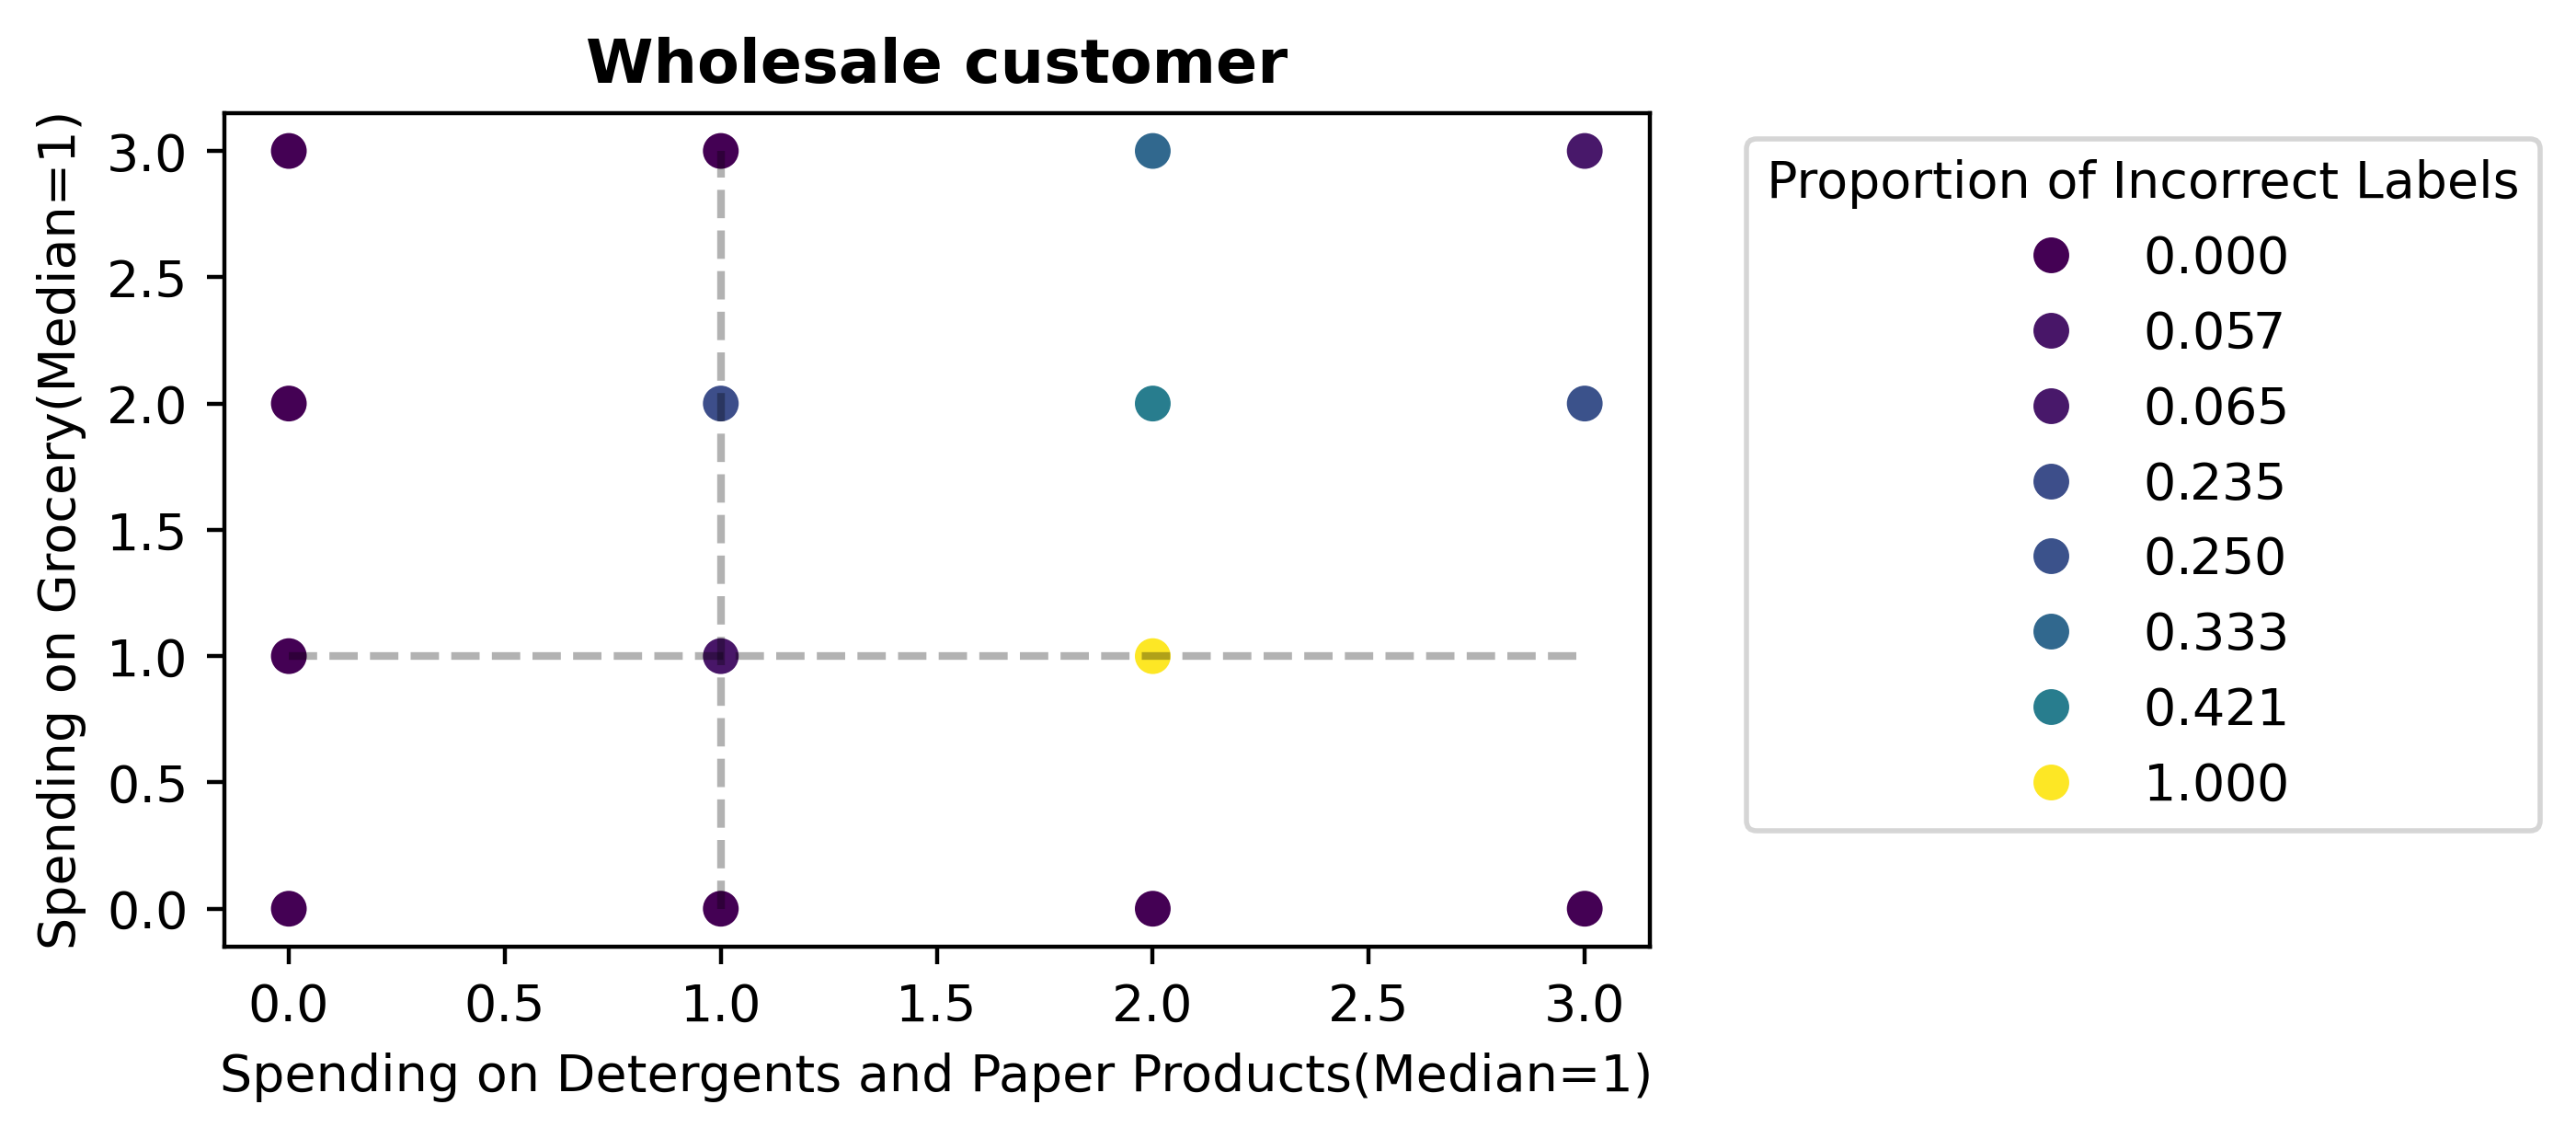

In [38]:

#Code to visualize the error in predictions made by Fast and Frugal Tree

L=pd.DataFrame()

plt.figure(figsize=(5,3), dpi=400)
for i in range(0,len(preds)):
    if Y_training.loc[i,:].values[0]==preds[i]:
        L=L.append([0])
    else:
        L=L.append([1])

X_vis=dataset_fft1.iloc[:,:6]
L.columns=["True/False"]
X_vis=pd.concat([X_vis,L["True/False"].reset_index(drop=True)],axis=1)
L1=X_vis.groupby([5,3], as_index=False).sum()
L2=X_vis.groupby([5,3], as_index=False).mean()
L2=L2[L1["True/False"]>1]
L1=L1[L1["True/False"]<=1]

#L1["True/False"]=0
L=pd.concat([L1,L2],axis=0)



scatter=plt.scatter(L[5],L[3],c=L["True/False"])

legend1 = plt.legend(*scatter.legend_elements(),bbox_to_anchor=(1.05, 1.0), loc='upper left'
                   , title="Proportion of Incorrect Labels")
#legend1.get_texts()[0].set_text('Incorrectly labeled')
#legend1.get_texts()[1].set_text('Correctly labeled') 


plt.title("Wholesale customer",fontweight='bold')
plt.xlabel("Spending on Detergents and Paper Products(Median=1)")
plt.ylabel("Spending on Grocery(Median=1)")
#plt.xlim((0.01,0.6))
#plt.ylim((0.01,0.6))
plt.plot([1,1],[0,3],linestyle = 'dashed',alpha=0.3,color="black")
plt.plot([0,3],[1,1],linestyle = 'dashed',alpha=0.3,color="black")
plt.show()

In [111]:
np.mean(data_f.iloc[:,:-2].std())

1.0476024365795407

In [11]:
#Synthetic Oracle for sequential labelling 

def DS(ds,trainstart,poolstart,trainend,r,data_f):
   if ds=="ground_dataset":
      dataset_ground=data_f.sample(frac=1.0,random_state=r).reset_index(drop=True)     
      X=dataset_ground.loc[:,att_start_w:att_end_w]
      Y=dataset_ground.loc[:,[y_index_w]]
      
   if ds=="Tallying":
      dataset_tall=dataset_tallying.sample(frac=1.0, random_state=r).reset_index(drop=True)
      
      
      X=dataset_tall.loc[:,att_start_w:att_end_w]
      Y=dataset_tall.loc[:,[y_index_w]]
      
   if ds=="FFT":
      dataset_fft=dataset_fft1.sample(frac=1.0,random_state=r).reset_index(drop=True) 
      X=dataset_fft.loc[:,att_start_w:att_end_w]
      Y=dataset_fft.loc[:,[y_index_w]]
 
   return X,Y

In [43]:
def Avg(lst):
    sum_of_list = 0
    for i in range(len(lst)):
        sum_of_list += sum(lst[i])
    average = sum_of_list/len(lst)
    return average

In [20]:

#Code for four Active Learning algorithms used for the study

import modAL 
from modAL import density
from modAL import uncertainty
import math
nos=1000
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import pearsonr




def ActiveLearner_pool(classifier,query_strategy,X,Y,X_test,Y_test):

    X_training, X_pool, Y_training,Y_new = train_test_split(X, Y, test_size=test_size, random_state=50,stratify=Y)
    Y_new=Y_new.reset_index(drop=True)
    Y_training=np.ravel(Y_training)
    X_training=X_training.reset_index(drop=True)
    X_pool=X_pool.reset_index(drop=True)   
    
    learner = ActiveLearner(estimator=classifier,query_strategy=query_strategy,X_training=X_training,y_training=Y_training)
    a=0
    i=0
    I=[poolstart]
    l=learner.score(X_test,Y_test)
    L=[learner.score(X_test,Y_test)]

    for i in range(0,len(X_pool)):
        X_pool=X_pool.reset_index(drop=True)
        Y_new=Y_new.reset_index(drop=True)
        query_idx, query_inst = learner.query(X_pool)
        X_pool=X_pool.drop(query_idx,axis=0)  
        y_new=Y_new.iloc[query_idx,0]
        #Y_new=np.delete(Y_new,query_idx,axis=0)    
        Y_new=Y_new.drop(query_idx,axis=0)
       
        learner.teach(query_inst,y_new)
        I.append(i)
        p=learner.score(X_test,Y_test)  
        if abs(l-p)<=0.001:
          a=a+1
        else: a=0
        if a>=nos:
           break
        l=p         
        L.append(l)
    return L




def newpoolseed(X_training,Y_training,X_pool,Y_new):
    #X_training=pd.DataFrame(X_training,columns=col_train_X)
    view1_pool=X_pool.loc[:,att_start_w:att_mid_w1]
    view2_pool=X_pool.loc[:,att_mid_w2:att_end_w]
    view1_training=X_training.loc[:,att_start_w:att_mid_w1]
    view2_training=X_training.loc[:,att_mid_w2:att_end_w]

    clf1= classifier.fit(view1_training,Y_training)
    clf1_predictions=clf1.predict(view1_pool)
    clf2= classifier.fit(view2_training,Y_training)
    clf2_predictions=clf2.predict(view2_pool)

    X_pool_remaining=[]
    X_pool_cotested=[]
    Y_new_cotested=[]
    Y_new_remaining=[]
    for i in range(len(X_pool)):
        if clf1_predictions[i]!=clf2_predictions[i]:
         
            X_pool_cotested.append(X_pool.iloc[i])
            Y_new_cotested.append(Y_new.iloc[i])
        else:
            X_pool_remaining.append(X_pool.iloc[i])
            Y_new_remaining.append(Y_new.iloc[i])

    X_pool_cotested=pd.DataFrame(X_pool_cotested,columns=X_pool.columns)
    X_pool_remaining=pd.DataFrame(X_pool_remaining,columns=X_pool.columns)
    Y_new_cotested=pd.DataFrame(Y_new_cotested)
    Y_new_remaining=pd.DataFrame(Y_new_remaining)
    X_pool_cotested=X_pool_cotested.reset_index(drop=True)
    X_pool_remaining=X_pool_remaining.reset_index(drop=True)
    Y_new_cotested=Y_new_cotested.reset_index(drop=True)
    Y_new_remaining=Y_new_remaining.reset_index(drop=True)

    return X_pool_cotested,X_pool_remaining,Y_new_cotested,Y_new_remaining









#Multiview-Cotesting 

def MV_Learning(X,Y,X_test,Y_test,classifier):

     
    X_training, X_pool, Y_training,Y_new = train_test_split(X, Y, test_size=test_size, random_state=50,stratify=Y)
    current_train_set=pd.merge(X_training,Y_training,left_index=True, right_index=True)
    Y_training=np.ravel(Y_training) 
    X_training=X_training.reset_index(drop=True)
    X_pool=X_pool.reset_index(drop=True)     
        
        
    view1_pool=X_pool.loc[:,att_start_w:att_mid_w1]
    view2_pool=X_pool.loc[:,att_mid_w2:att_end_w]
    view1_training=X_training.loc[:,att_start_w:att_mid_w1]
    view2_training=X_training.loc[:,att_mid_w2:att_end_w]

    clf1= classifier.fit(view1_training,Y_training)
    clf1_predictions=clf1.predict(view1_pool)
    clf2= classifier.fit(view2_training,Y_training)
    clf2_predictions=clf2.predict(view2_pool)

    
    X_pool_remaining=[]
    X_pool_cotested=[]
    Y_new_cotested=[]
    Y_new_remaining=[]
    for i in range(len(X_pool)):
        if clf1_predictions[i]!=clf2_predictions[i]:
            X_pool_cotested.append(X_pool.iloc[i])
            Y_new_cotested.append(Y_new.iloc[i])
        else:
            X_pool_remaining.append(X_pool.iloc[i])
            Y_new_remaining.append(Y_new.iloc[i])

    X_pool_cotested=pd.DataFrame(X_pool_cotested,columns=X_pool.columns)
    X_pool_remaining=pd.DataFrame(X_pool_remaining,columns=X_pool.columns)
    Y_new_cotested=pd.DataFrame(Y_new_cotested)
    Y_new_remaining=pd.DataFrame(Y_new_remaining)
    X_pool_cotested=X_pool_cotested.reset_index(drop=True)
    X_pool_remaining=X_pool_remaining.reset_index(drop=True)
    Y_new_cotested=Y_new_cotested.reset_index(drop=True)
    Y_new_remaining=Y_new_remaining.reset_index(drop=True)
    #col_train_X=X_training.columns
    #X_training=np.array(X_training)
    classifier=LogisticRegression()
    learner = ActiveLearner(estimator=classifier,query_strategy=entropy_sampling,X_training=X_training,y_training=Y_training)
    l=learner.score(X_test,Y_test)
  
    L=[learner.score(X_test,Y_test)]
    a=0
    p=0
    for query_idx in range(0,len(X_pool)):
        X_pool_cotested,X_pool_remaining,Y_new_cotested,Y_new_remaining=newpoolseed(X_training,Y_training,X_pool,Y_new)
        if len(X_pool_cotested)!=0:                
            X_pool_cotested=X_pool_cotested.reset_index(drop=True)
            Y_new_cotested=Y_new_cotested.reset_index(drop=True)
            query_idx, query_inst = learner.query(X_pool_cotested)
            X_pool_cotested=X_pool_cotested.drop(query_idx,axis=0)  
            y_new=Y_new_cotested.iloc[query_idx,0]
            #Y_new=np.delete(Y_new,query_idx,axis=0)    
            Y_new_cotested=Y_new_cotested.drop(query_idx,axis=0)   
            learner.teach(query_inst,y_new)
            p=learner.score(X_test,Y_test)
            if abs(l-p)<=0.001:
                a=a+1
            else: a=0
            if a>=nos:
                break
            l=p         
            L.append(l)
            X_pool=X_pool_cotested.append(X_pool_remaining)
            Y_new=Y_new_cotested.append(Y_new_remaining)
            X_training=X_training.append(pd.DataFrame(query_inst,columns=X_training.columns))
            Y_training=np.append(Y_training,y_new,axis=0)
            query_inst=pd.DataFrame(query_inst,columns=X_pool.columns)
    
            new_instance=pd.merge(query_inst,y_new,left_index=True, right_index=True)
            current_train_set=pd.concat([current_train_set, new_instance], ignore_index=True, sort=False)
            current_train_set=current_train_set.reset_index(drop=True)
        
        else:
            X_pool_remaining=X_pool_remaining.reset_index(drop=True)
            Y_new_remaining=Y_new_remaining.reset_index(drop=True)
          
            query_idx, query_inst = learner.query(X_pool_remaining)
            X_pool_remaining=X_pool_remaining.drop(query_idx,axis=0)  
            y_new=Y_new_remaining.iloc[query_idx,0]
         
            
            Y_new_remaining=Y_new_remaining.drop(query_idx,axis=0)   
            learner.teach(query_inst,y_new)
            p=learner.score(X_test,Y_test)
            if abs(l-p)<=0.001:
                a=a+1
            else: a=0
            if a>=nos:
                break
            l=p         
            L.append(l)
            X_pool=X_pool_cotested.append(X_pool_remaining)
            Y_new=Y_new_cotested.append(Y_new_remaining)
            X_training=X_training.append(pd.DataFrame(query_inst,columns=X_training.columns))
            Y_training=np.append(Y_training,y_new,axis=0)
            query_inst=pd.DataFrame(query_inst,columns=X_pool.columns)
          
            new_instance=pd.merge(query_inst,y_new,left_index=True, right_index=True)
            current_train_set=pd.concat([current_train_set, new_instance], ignore_index=True, sort=False)
            current_train_set=current_train_set.reset_index(drop=True)
            

    return L


def density_based_on_biased_attributes(current_train_set,X_entire):


    biased_attributes=[]
    max_corr=[]

    for i in range(0,current_train_set.shape[1]-1):
         pvalue=pearsonr(current_train_set.loc[:,i], current_train_set.loc[:,y_index_w])[1]
  
         if pvalue<=0.001:
            biased_attributes.append(i)
           
    if len(biased_attributes)>0:
    
        density=modAL.density.information_density(X_entire.loc[:,biased_attributes],"euclidean")
        
    else:
        density=np.zeros(len(X_entire))

  
    density=pd.DataFrame(density,columns=["density"])

    
    biased_attributes.sort()

    return density,biased_attributes




def Inverse_informativeness(X_pool,Y_new,current_train_set,biased_attributes_consistency,biased_attributes,density_min,density_max,coeff):
    
 
    X_current=current_train_set.loc[:,:att_end_w].copy()
    X_entire=pd.concat([X_pool,X_current], ignore_index=True, sort=False).copy()

    X_entire=X_entire.reset_index(drop=True)
    e = uncertainty.classifier_uncertainty(classifier=classifier,X=X_pool)
    e=pd.DataFrame(e)


    if len(current_train_set)==poolstart:
     
        density_min=e.loc[:,0].min()

        density_max=e.loc[:,0].max()

        
    density,biased_attributes_new=density_based_on_biased_attributes(current_train_set,X_entire)
    if biased_attributes_new==biased_attributes:
        biased_attributes_consistency=biased_attributes_consistency+1
    else:
        biased_attributes_consistency=0
        
        
        
    

    density=density.loc[:len(X_pool)-1,:].copy()


    
    
    
    
    biased_attributes=biased_attributes_new
    
    


    output=pd.DataFrame()   
    
    output=pd.DataFrame()
    output["output"]=e.loc[:,0]-(density.loc[:,"density"]*coeff)
    output=pd.DataFrame(output,columns=["output"])
    
    X_dp=pd.merge(X_pool,output,left_index=True, right_index=True)

    dataset=pd.merge(X_dp,Y_new,left_index=True, right_index=True)

    dataset=dataset.sort_values(by="output",ascending=False)
    dataset=dataset.drop(["output"],axis=1)
    dataset=dataset.reset_index(drop=True)
    X_pool=dataset.loc[:,att_start_w:att_end_w].copy()
    Y_new=dataset.loc[:,[y_index_w]].copy()
    dataset=dataset.drop(0,axis=0)
    dataset=dataset.reset_index(drop=True)

  
    return X_pool,Y_new,biased_attributes_consistency,biased_attributes,density_min,density_max





def Inverse_Density_learning(X,Y,X_test,Y_test,classifier,coeff):
    
    X_training, X_pool, Y_training,Y_new = train_test_split(X, Y, test_size=test_size, random_state=50,stratify=Y)

    X_pool=X_pool.reset_index(drop=True)
    Y_new=Y_new.reset_index(drop=True)
    X_training=X_training.reset_index(drop=True)
    Y_training=Y_training.reset_index(drop=True)
    current_train_set=pd.merge(X_training,Y_training,left_index=True, right_index=True)
    Y_training=np.ravel(Y_training)
    X_training=np.array(X_training)
    
    
    
    learner = ActiveLearner(estimator=classifier,X_training=X_training,y_training=Y_training)
    a=0
    i=0
    I=[poolstart]
    l=learner.score(X_test,Y_test)
    L=[learner.score(X_test,Y_test)]
    p=0
    density_min=0
    density_max=0
 

    biased_attributes_consistency=0

    biased_attributes=[]
    for query_idx in range(0,len(X_pool)):
        X_pool=X_pool.reset_index(drop=True)
        Y_new=Y_new.reset_index(drop=True)
        X_pool,Y_new,biased_attributes_consistency,biased_attributes,density_min,density_max=Inverse_informativeness(X_pool,Y_new,current_train_set,biased_attributes_consistency,biased_attributes,density_min,density_max,coeff)
        query_inst=np.array(X_pool.loc[0]).reshape(1,-1)
        X_pool=X_pool.drop(0,axis=0)
        y_new=Y_new.iloc[0,0]
        Y_new=Y_new.drop(0,axis=0)
      
        learner.teach(query_inst,[y_new])
        query_inst=pd.DataFrame(query_inst,columns=X_pool.columns)
        y_new=pd.DataFrame([y_new],columns=Y_new.columns)
        new_instance=pd.merge(query_inst,y_new,left_index=True, right_index=True)

        current_train_set=pd.concat([current_train_set, new_instance], ignore_index=True, sort=False)
        current_train_set=current_train_set.reset_index(drop=True)
        I.append(i)
        p=learner.score(X_test,Y_test)
    
        if abs(l-p)<=0.001:
            a=a+1
        else: a=0
        if a>=nos:
            break
        l=p         
        L.append(l)
    return L,current_train_set




def informativeness(X_pool,Y_new,current_train_set,biased_attributes_consistency,biased_attributes,density_min,density_max,coeff):
    

    X_current=current_train_set.loc[:,:att_end_w].copy()
    X_entire=pd.concat([X_pool,X_current], ignore_index=True, sort=False).copy()

    
    X_entire=X_entire.reset_index(drop=True)
    e = uncertainty.classifier_uncertainty(classifier=classifier,X=X_pool)
    e=pd.DataFrame(e)


    if len(current_train_set)==poolstart:
     
        density_min=e.loc[:,0].min()

        density_max=e.loc[:,0].max()

        
    density,biased_attributes_new=density_based_on_biased_attributes(current_train_set,X_entire)
    if biased_attributes_new==biased_attributes:
        biased_attributes_consistency=biased_attributes_consistency+1
    else:
        biased_attributes_consistency=0
        
        

    density=density.loc[:len(X_pool)-1,:].copy()


    
    
    
    
    biased_attributes=biased_attributes_new
    
    

    output=pd.DataFrame()


    
    
    output=pd.DataFrame()
    output["output"]=e.loc[:,0]*(density.loc[:,"density"]**coeff)
    output=pd.DataFrame(output,columns=["output"])
    
    X_dp=pd.merge(X_pool,output,left_index=True, right_index=True)

    dataset=pd.merge(X_dp,Y_new,left_index=True, right_index=True)

    dataset=dataset.sort_values(by="output",ascending=False)
    dataset=dataset.drop(["output"],axis=1)
    dataset=dataset.reset_index(drop=True)
    X_pool=dataset.loc[:,att_start_w:att_end_w].copy()
    Y_new=dataset.loc[:,[y_index_w]].copy()
    dataset=dataset.drop(0,axis=0)
    dataset=dataset.reset_index(drop=True)


  
    return X_pool,Y_new,biased_attributes_consistency,biased_attributes,density_min,density_max







def Density_learning(X,Y,X_test,Y_test,classifier,coeff):
    
    X_training, X_pool, Y_training,Y_new = train_test_split(X, Y, test_size=test_size, random_state=50,stratify=Y)

    X_pool=X_pool.reset_index(drop=True)
    Y_new=Y_new.reset_index(drop=True)
    X_training=X_training.reset_index(drop=True)
    Y_training=Y_training.reset_index(drop=True)
    current_train_set=pd.merge(X_training,Y_training,left_index=True, right_index=True)
    Y_training=np.ravel(Y_training)
    X_training=np.array(X_training)
    
    
    
    learner = ActiveLearner(estimator=classifier,X_training=X_training,y_training=Y_training)
    a=0
    i=0
    I=[poolstart]
    l=learner.score(X_test,Y_test)
    L=[learner.score(X_test,Y_test)]
    p=0
    density_min=0
    density_max=0
 

    biased_attributes_consistency=0

    biased_attributes=[]
    for query_idx in range(0,len(X_pool)):
        X_pool=X_pool.reset_index(drop=True)
        Y_new=Y_new.reset_index(drop=True)
        X_pool,Y_new,biased_attributes_consistency,biased_attributes,density_min,density_max=informativeness(X_pool,Y_new,current_train_set,biased_attributes_consistency,biased_attributes,density_min,density_max,coeff)
        query_inst=np.array(X_pool.loc[0]).reshape(1,-1)
        X_pool=X_pool.drop(0,axis=0)
        y_new=Y_new.iloc[0,0]
        Y_new=Y_new.drop(0,axis=0)

        learner.teach(query_inst,[y_new])
        query_inst=pd.DataFrame(query_inst,columns=X_pool.columns)
        y_new=pd.DataFrame([y_new],columns=Y_new.columns)
        new_instance=pd.merge(query_inst,y_new,left_index=True, right_index=True)

        current_train_set=pd.concat([current_train_set, new_instance], ignore_index=True, sort=False)
        current_train_set=current_train_set.reset_index(drop=True)
        I.append(i)
        p=learner.score(X_test,Y_test)
    
        if abs(l-p)<=0.001:
            a=a+1
        else: a=0
        if a>=nos:
            break
        l=p         
        L.append(l)
    return L,current_train_set





    
def Random(X,Y,X_test,Y_test,classifier):
    
    
    
    X_training, X_pool, Y_training,Y_new = train_test_split(X, Y, test_size=test_size, random_state=50,stratify=Y)
    X_pool=X_pool.reset_index(drop=True)
    Y_training=np.ravel(Y_training)
    X_training=X_training.reset_index(drop=True)
    Y_new=Y_new.reset_index(drop=True)
    X_training=np.array(X_training)
                   
            
    
    
    learner = ActiveLearner(estimator=classifier,X_training=X_training,y_training=Y_training)
    a=0
    i=0
    I=[poolstart]
    l=learner.score(X_test,Y_test)
    L=[learner.score(X_test,Y_test)]
    bench_nos=0
    for query_idx in range(0,len(X_pool)):
        X_pool=X_pool.reset_index(drop=True)
        Y_new=Y_new.reset_index(drop=True)
        query_inst=np.array(X_pool.loc[0]).reshape(1,-1)
        X_pool=X_pool.drop(0,axis=0)  
        y_new=Y_new.iloc[0,0]
        #Y_new=np.delete(Y_new,query_idx,axis=0)    
        Y_new=Y_new.drop(0,axis=0)
        learner.teach(query_inst,[y_new])
        I.append(i)
        p=learner.score(X_test,Y_test)
        if abs(l-p)<=0.001:
            a=a+1
        else: a=0
        if a>=nos:
            break
        l=p         
        L.append(l)
    return L


In [ ]:
#Code to visualise the querying order of Density learning

#This code could be accordingly changed to visualize the querying order of other AL algorithms

q="FFT_1"

trainstart=0
trainend=round(len(data_f))
poolstart=8
coeff_list=[4]

coeff=4
coeff_den=1


ACC_Tallying=pd.DataFrame(columns=coeff_list)

for coeff in coeff_list:   
      print(q)
      cross_range=1
      X_test=data_test.loc[:,att_start_w:att_end_w]
      Y_test=data_test.loc[:,[y_index_w]]


      k=[]
      S=[] 

      for r in range(0,cross_range):
          X,Y=DS(q,trainstart=trainstart,poolstart=poolstart,trainend=trainend,r=r,data_f=data_f)


          classifier=LogisticRegression()



          L,current_train_set=Density_learning(X=X,Y=Y,X_test=X_test,
                                               Y_test=Y_test,classifier=classifier,coeff=coeff_den) 
          #L,current_train_set=MV_Learning(X=X,Y=Y,X_test=X_test,Y_test=Y_test,classifier=classifier)     

          k.append(L)
          S.append(len(L))

      k=pd.DataFrame(k)
      L=k.mean(axis=0)
      S=pd.DataFrame(S)


      fin=round(S.max(axis=0)).astype(int)
      try:
           L=L[0:fin[0]]
      except:
           continue
      I=[]
      for i in range(poolstart,poolstart+len(L)):
          I.append(i)
      print("Inverse_Density")              


   
      plt.show()
      ACC_Tallying.loc[:,coeff]=L
   



        
for i in coeff_list:
    plt.plot(I,ACC_Tallying.loc[:,i],label=i)
    
plt.legend()
plt.show()

PHASE 2:

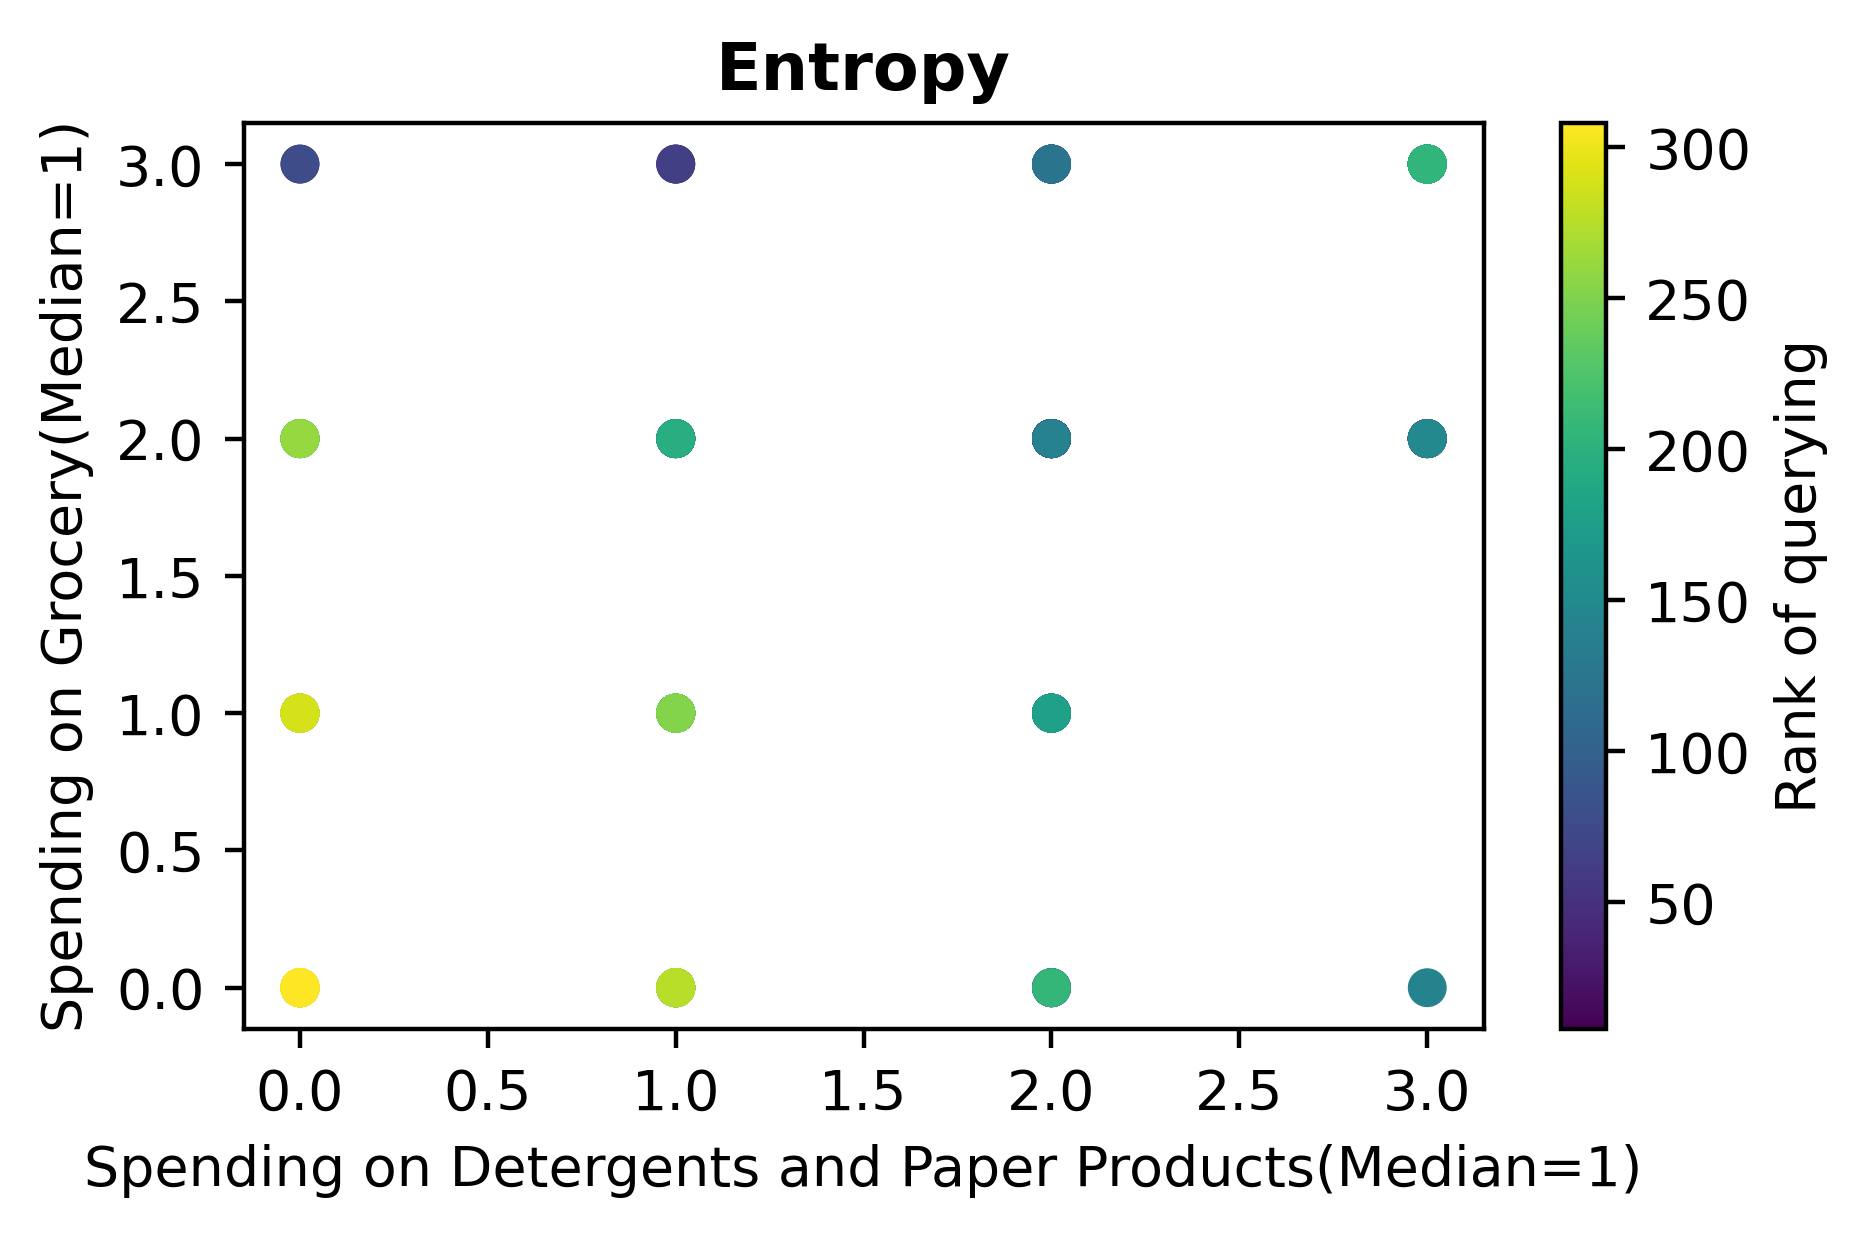

In [50]:

#Querying order of Entropy sampling

asd=current_train_set.copy()
asd=asd.reset_index()
asd=asd.loc[poolstart:,]

plt.figure(figsize=(5,3), dpi=400)

sc = plt.scatter(asd.loc[:,5], asd.loc[:,3], c=asd.loc[:,"index"])
plt.colorbar(sc, label="Rank of querying")



plt.title("Entropy",fontweight="bold")
plt.xlabel("Spending on Detergents and Paper Products(Median=1)")
plt.ylabel("Spending on Grocery(Median=1)")



plt.show()

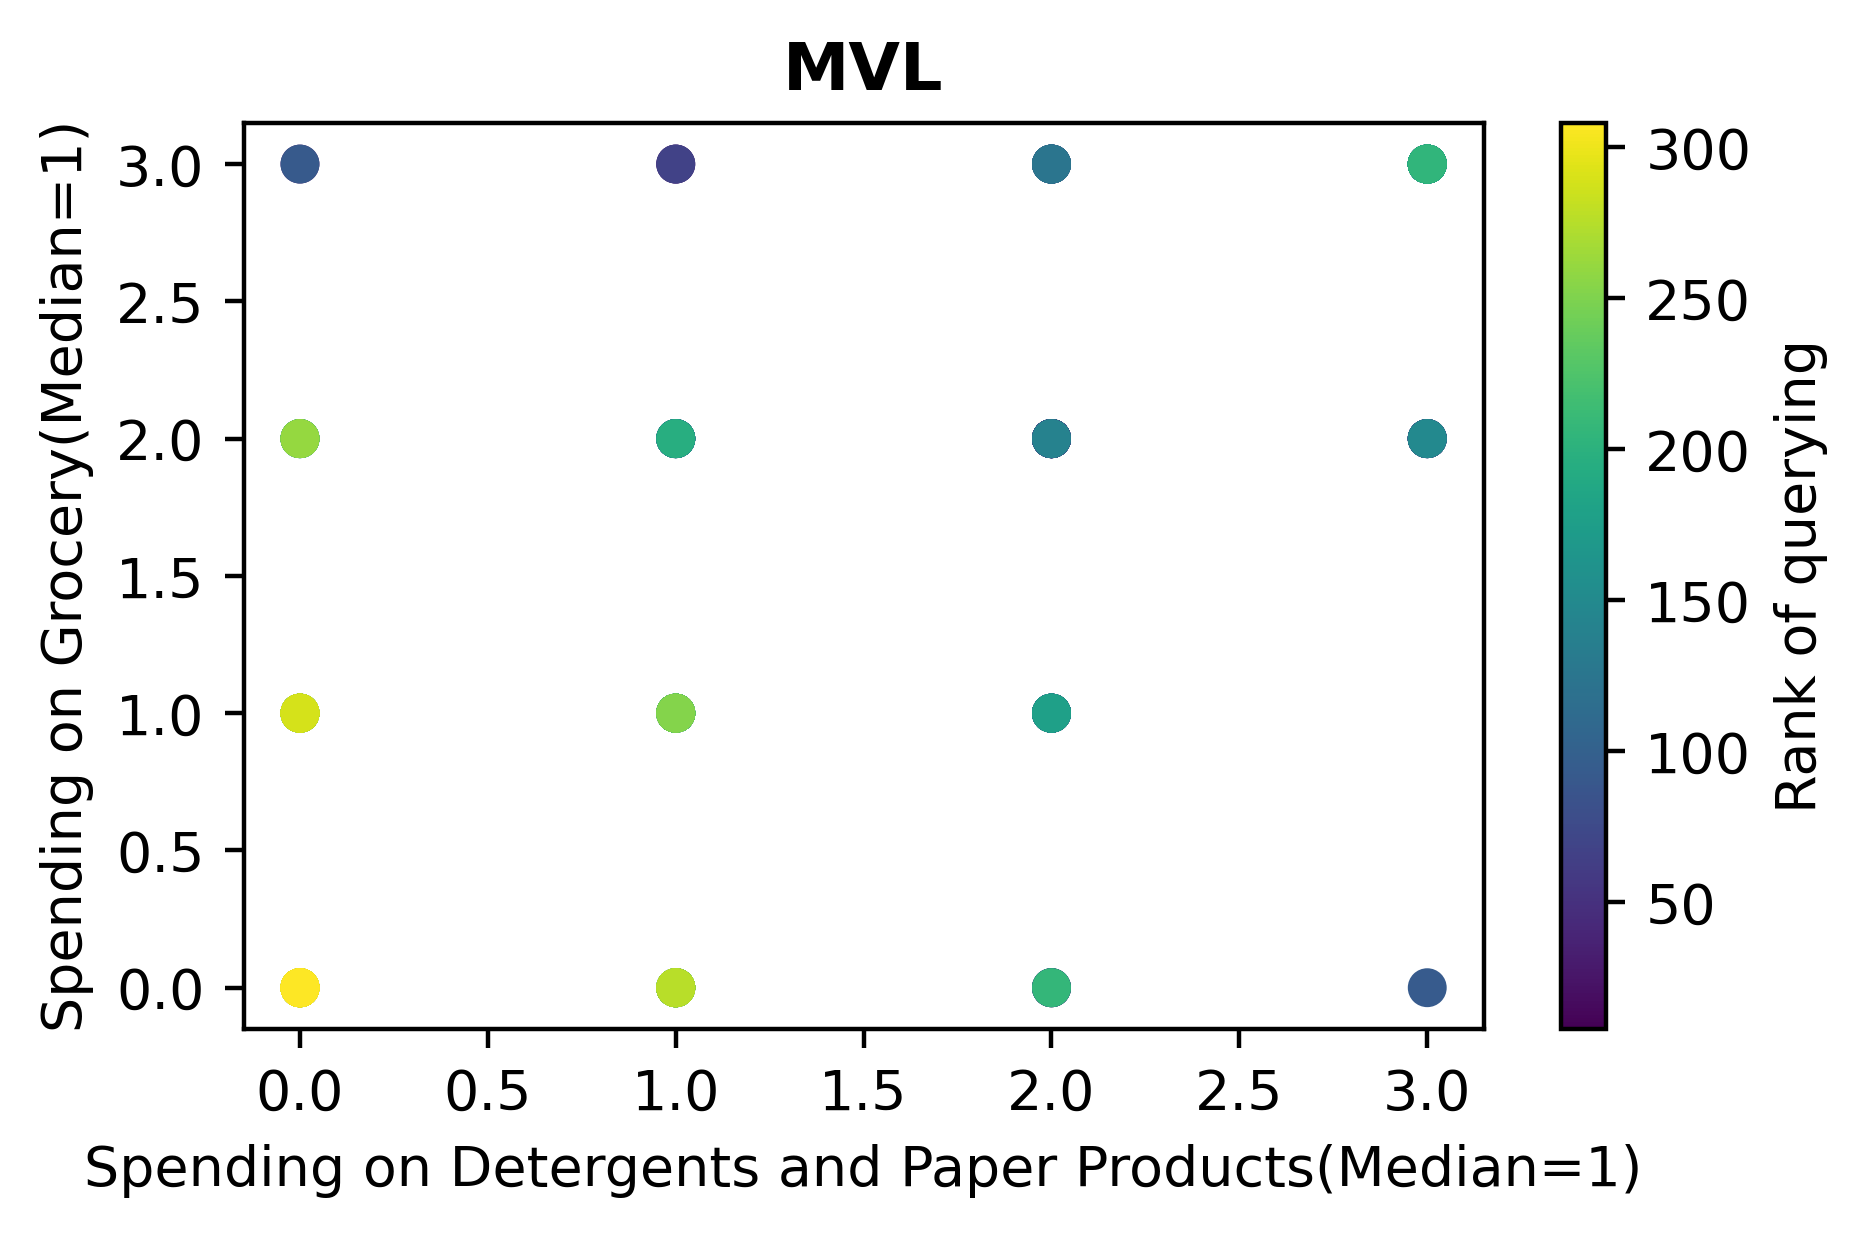

In [52]:

#Querying order of MVL

asd=current_train_set.copy()
asd=asd.reset_index()
asd=asd.loc[poolstart:,]

plt.figure(figsize=(5,3), dpi=400)

sc = plt.scatter(asd.loc[:,5], asd.loc[:,3], c=asd.loc[:,"index"])
plt.colorbar(sc, label="Rank of querying")



plt.title("MVL",fontweight="bold")
plt.xlabel("Spending on Detergents and Paper Products(Median=1)")
plt.ylabel("Spending on Grocery(Median=1)")



plt.show()

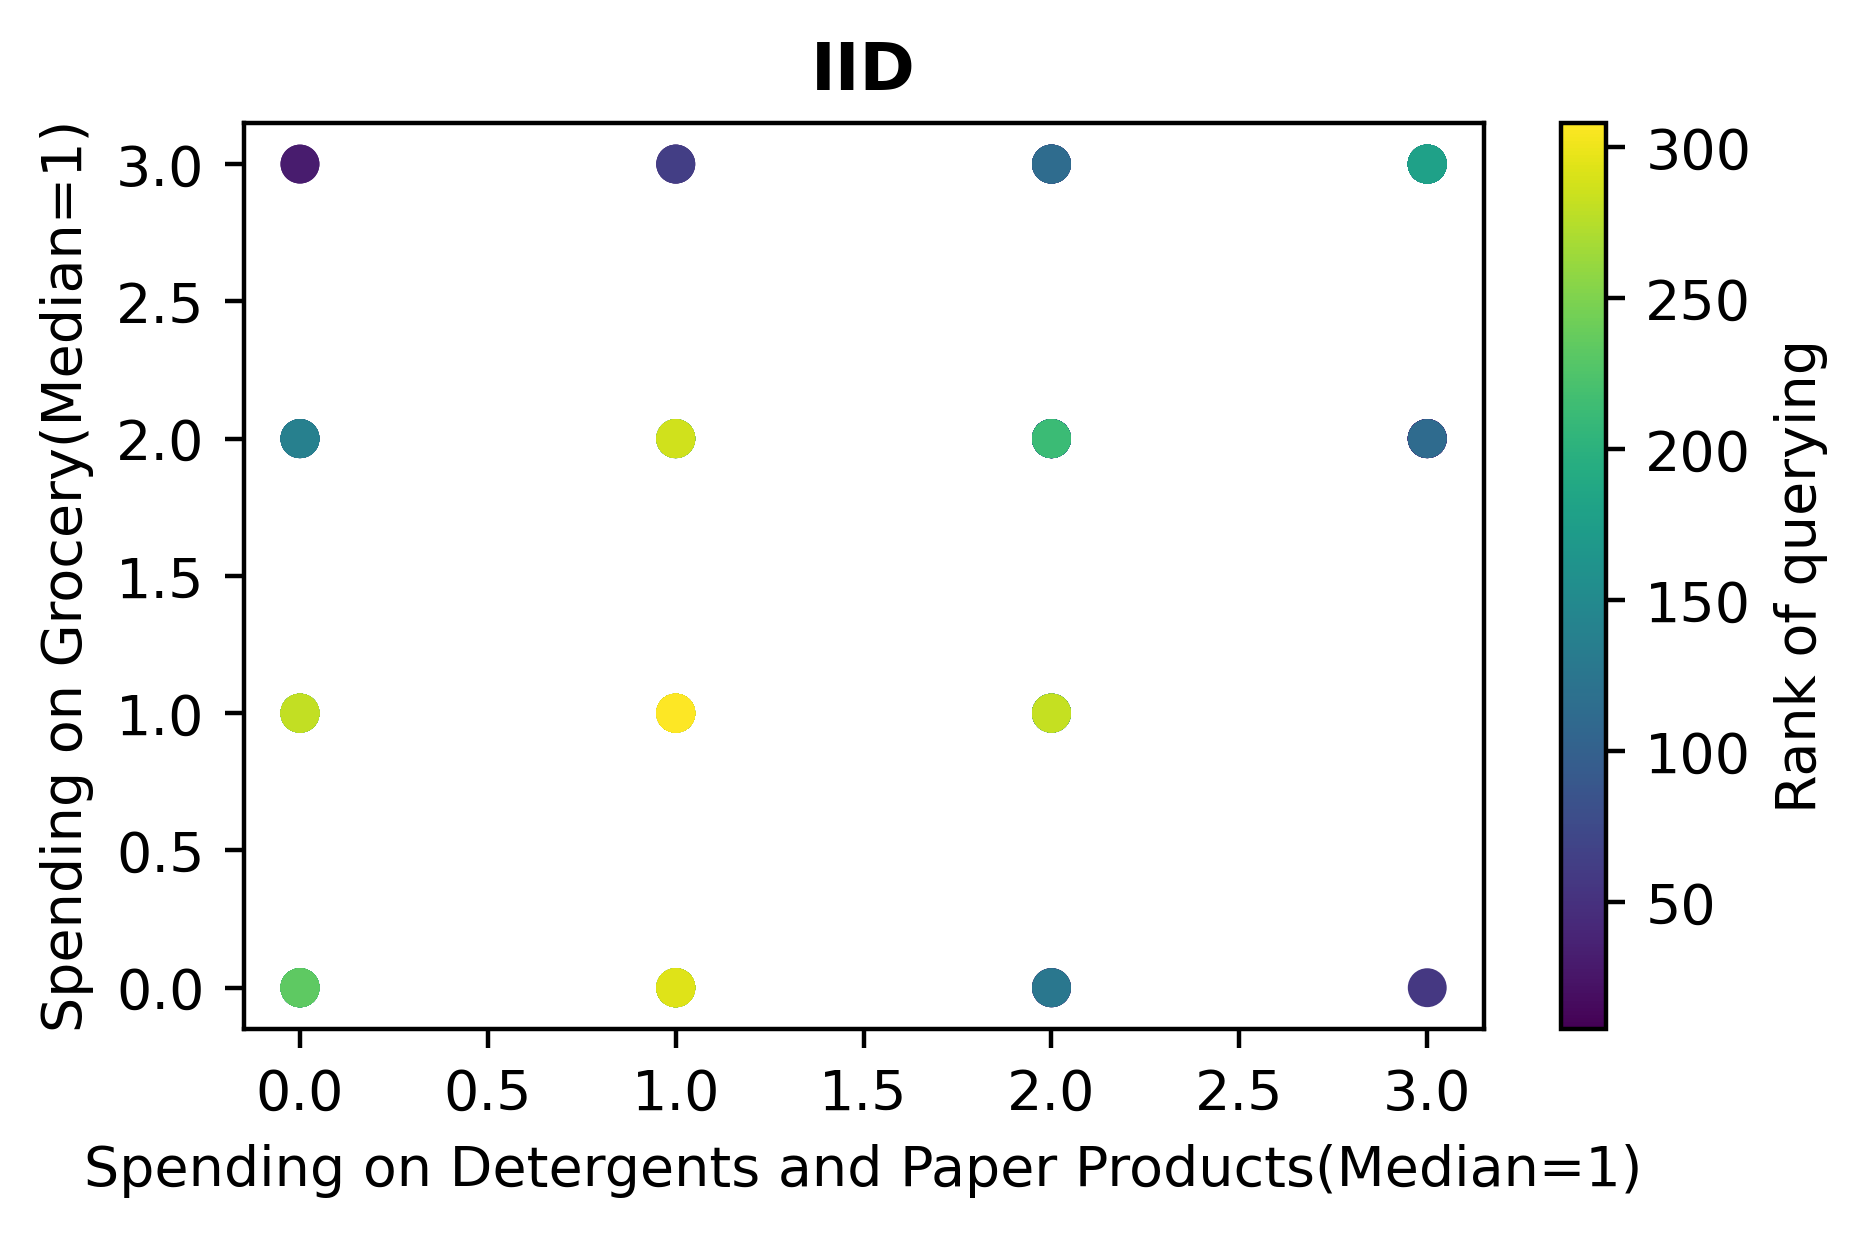

In [54]:


#Querying order of the proposed IID

asd=current_train_set.copy()
asd=asd.reset_index()
asd=asd.loc[poolstart:,]

plt.figure(figsize=(5,3), dpi=400)

sc = plt.scatter(asd.loc[:,5], asd.loc[:,3], c=asd.loc[:,"index"])
plt.colorbar(sc, label="Rank of querying")



plt.title("IID",fontweight="bold")
plt.xlabel("Spending on Detergents and Paper Products(Median=1)")
plt.ylabel("Spending on Grocery(Median=1)")



plt.show()

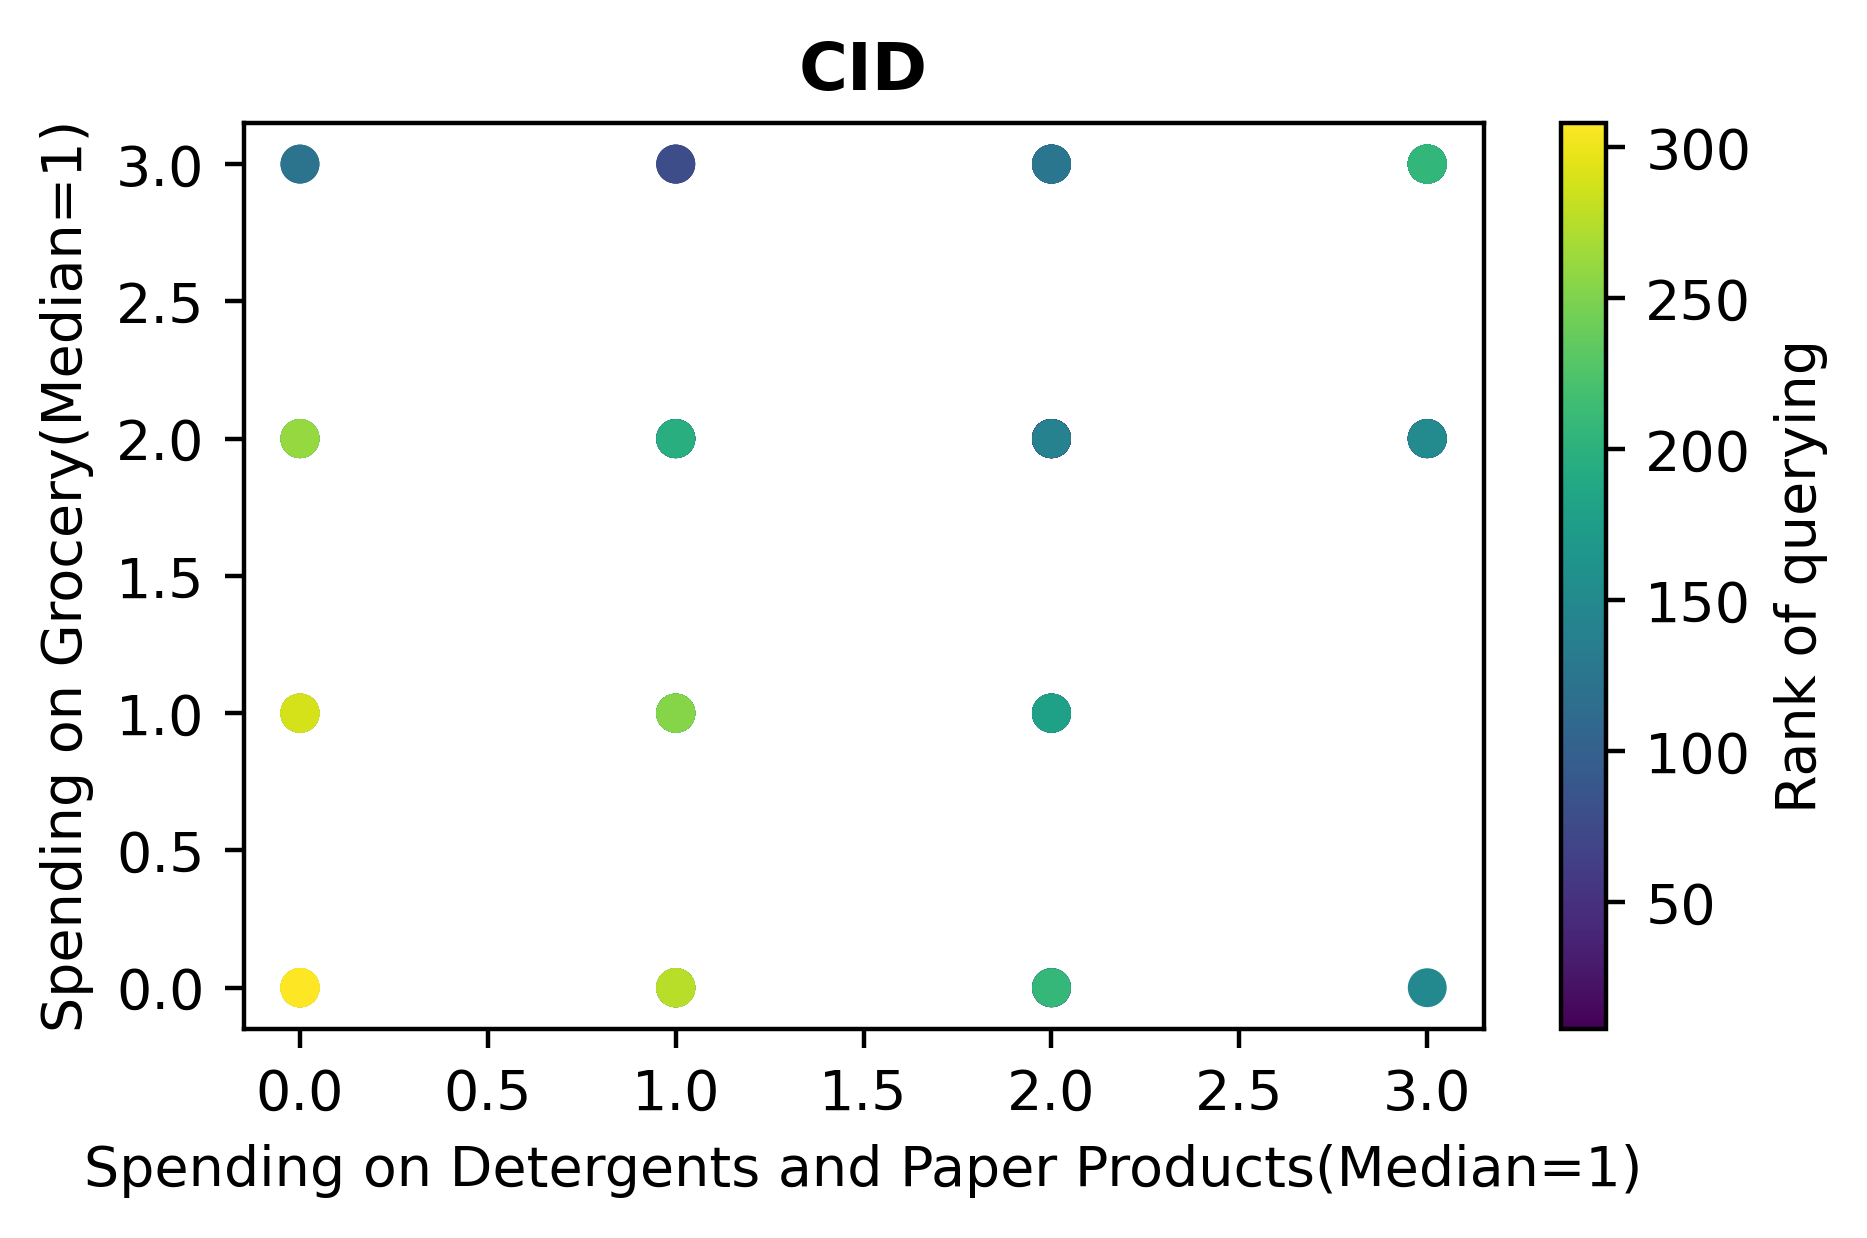

In [56]:

#Querying order of CID


asd=current_train_set.copy()
asd=asd.reset_index()
asd=asd.loc[poolstart:,]

plt.figure(figsize=(5,3), dpi=400)

sc = plt.scatter(asd.loc[:,5], asd.loc[:,3], c=asd.loc[:,"index"])
plt.colorbar(sc, label="Rank of querying")



plt.title("CID",fontweight="bold")
plt.xlabel("Spending on Detergents and Paper Products(Median=1)")
plt.ylabel("Spending on Grocery(Median=1)")



plt.show()

PHASE 3:

In [ ]:
#LR Classifier and Ground Truth labels

Avg_lr=pd.DataFrame(columns=["ground_dataset","FFT_1"])
AL=["Entropy","MVL","Inverse_Density","Random","Density"]

Q=["ground_dataset"]
L_1=[]
L_2=[]
L_3=[]
L_4=[]
L_5=[]
Total_lr=pd.DataFrame()
Bench_lr=pd.DataFrame()
test_size=0.9
trainstart=0
trainend=len(data_f)
poolstart=30

coeff=4 #Based on average similarity
coeff_den=1

for q in list(Q):     
       print(q)
       cross_range=30
       X_test=data_test.loc[:,att_start_w:att_end_w]
       Y_test=data_test.loc[:,[y_index_w]]
        
       for al in list(AL):           
        
           if al=="Entropy":
              #fit model to data
              k=[]
              S=[]
              bench=[]
              for r in range(0,cross_range):
                  X,Y=DS(q,trainstart=trainstart,poolstart=poolstart,trainend=trainend,r=r,data_f=data_f)

                  #Y_new=np.ravel(Y_new)
                  
                  #Tuning for knn
                  classifier=LogisticRegression()                                             
               
                  
                  L=ActiveLearner_pool(classifier=classifier,query_strategy=entropy_sampling,
                                         X=X,Y=Y,X_test=X_test,Y_test=Y_test)
                  k.append(L)
                  S.append(len(L))
                 
                              
              k=pd.DataFrame(k)
              L=k.mean(axis=0)
              S=pd.DataFrame(S)
              
              fin=round(S.max(axis=0)).astype(int)
              try:
                   L=L[0:fin[0]]
              except:
                   continue
              I=[]
              for i in range(poolstart,poolstart+len(L)):
                  I.append(i)
              print("Entropy")            
              Avg_lr.loc[al,q]=sum(L)/len(L)
              Total_lr.loc[al,q]=len(L)
              
              I_1=I
              L_1=L
              

 
               
               

           if al=="MVL":
              k=[]
              S=[] 
             
              for r in range(0,cross_range):
                  X,Y=DS(q,trainstart=trainstart,poolstart=poolstart,trainend=trainend,r=r,data_f=data_f)
     
                  
                  classifier=LogisticRegression()                                              
                   
                  L=MV_Learning(X=X,Y=Y,X_test=X_test,Y_test=Y_test,classifier=classifier)             
                  k.append(L)
                  S.append(len(L))
               

              k=pd.DataFrame(k)
              L=k.mean(axis=0)
              S=pd.DataFrame(S)
            
              fin=round(S.max(axis=0)).astype(int)
              try:
                   L=L[0:fin[0]]
              except:
                   continue
              I=[]
              for i in range(poolstart,poolstart+len(L)):
                  I.append(i)
              print("MVL")              
              
              Avg_lr.loc[al,q]=sum(L)/len(L)  
              Total_lr.loc[al,q]=len(L)
              I_2=I
              L_2=L
              

           
          
             
           if al=="Inverse_Density":
              k=[]
              S=[] 
          
              for r in range(0,cross_range):
                  X,Y=DS(q,trainstart=trainstart,poolstart=poolstart,trainend=trainend,r=r,data_f=data_f)

                
                  classifier=LogisticRegression()                                            

                  
                
                
                  L,current_train_set=Inverse_Density_learning(X=X,Y=Y,X_test=X_test,
                                               Y_test=Y_test,classifier=classifier,coeff=coeff)             
                      
                  k.append(L)
                  S.append(len(L))
                  
              k=pd.DataFrame(k)
              L=k.mean(axis=0)
              S=pd.DataFrame(S)
             
        
              fin=round(S.max(axis=0)).astype(int)
              try:
                   L=L[0:fin[0]]
              except:
                   continue
              I=[]
              for i in range(poolstart,poolstart+len(L)):
                  I.append(i)
              print("Inverse_Density")              
              
              Total_lr.loc[al,q]=len(L)
              Avg_lr.loc[al,q]=sum(L)/len(L)
              I_3=I
              L_3=L
              

          
           if al=="Density":
              k=[]
              S=[] 
          
              for r in range(0,cross_range):
                  X,Y=DS(q,trainstart=trainstart,poolstart=poolstart,trainend=trainend,r=r,data_f=data_f)

                
                  classifier=LogisticRegression()                                            

                  
                
                
                  L,current_train_set=Density_learning(X=X,Y=Y,X_test=X_test,
                                               Y_test=Y_test,classifier=classifier,coeff=coeff_den)             
                      
                  k.append(L)
                  S.append(len(L))
                  
              k=pd.DataFrame(k)
              L=k.mean(axis=0)
              S=pd.DataFrame(S)
             
        
              fin=round(S.max(axis=0)).astype(int)
              try:
                   L=L[0:fin[0]]
              except:
                   continue
              I=[]
              for i in range(poolstart,poolstart+len(L)):
                  I.append(i)
              print("Density")              
              
              Total_lr.loc[al,q]=len(L)
              Avg_lr.loc[al,q]=sum(L)/len(L)
              I_4=I
              L_4=L
              

              
           if al=="Random":
              k=[]
              S=[] 
          
              for r in range(0,cross_range):
                  X,Y=DS(q,trainstart=trainstart,poolstart=poolstart,trainend=trainend,r=r,data_f=data_f)

                
                  classifier=LogisticRegression()                                          

                  
                
                
                  L=Random(X=X,Y=Y,X_test=X_test,
                                               Y_test=Y_test,classifier=classifier)             
                      
                  k.append(L)
                  S.append(len(L))
                  
              k=pd.DataFrame(k)
              L=k.mean(axis=0)
              S=pd.DataFrame(S)
             
        
              fin=round(S.max(axis=0)).astype(int)
              try:
                   L=L[0:fin[0]]
              except:
                   continue
              I=[]
              for i in range(poolstart,poolstart+len(L)):
                  I.append(i)
              print("Random")              
              
              Total_lr.loc[al,q]=len(L)
              Avg_lr.loc[al,q]=sum(L)/len(L)
              I_5=I
              L_5=L
              
     

      
      

       plt.plot(I_1,L_1,label="Entropy")
       plt.plot(I_2,L_2,label="MVL")
       plt.plot(I_3,L_3,label="Inverse_Density")
       plt.plot(I_4,L_4,label="Density")
       plt.plot(I_5,L_5,label="Random")
    
       dict={"Entropy":L_1,'MVL' : L_2,'Inverse_Density' : L_3,'Density':L_4,"Random":L_5 }
       Ground_Data = pd.DataFrame(dict)
        
        
       plt.xlim([poolstart,Total_lr[q].max()])
       #plt.ylim([0.45,0.9])
       plt.legend()
       #plt.title((q)+data_name)
       plt.show()
       print(q)

In [ ]:
#LR Classifier and Tallying

Avg_lr=pd.DataFrame(columns=["ground_dataset","FFT_1"])
AL=["Entropy","MVL","Inverse_Density","Random","Density"]
#AL=["Entropy","Density","Inverse_Density"]
#AL=["MVL"]
#Q=["ground_dataset","Franklins_Rule","TTB","FFT_1","Dawes_Rule","Tallying"]
#Q=["FFT_1"]
Q=["Tallying"]
L_1=[]
L_2=[]
L_3=[]
L_4=[]
L_5=[]
Total_lr=pd.DataFrame()
Bench_lr=pd.DataFrame()
trainstart=0
trainend=len(data_f)
poolstart=30

coeff=4
coeff_den=1

for q in list(Q):     
       print(q)
       cross_range=30
       X_test=data_test.loc[:,att_start_w:att_end_w]
       Y_test=data_test.loc[:,[y_index_w]]
        
       for al in list(AL):           
        
           if al=="Entropy":
              #fit model to data
              k=[]
              S=[]
              bench=[]
              for r in range(0,cross_range):
                  X,Y=DS(q,trainstart=trainstart,poolstart=poolstart,trainend=trainend,r=r,data_f=data_f)

                  #Y_new=np.ravel(Y_new)
                  
                  #Tuning for knn
                  classifier=LogisticRegression()                                             
               
                  
                  L=ActiveLearner_pool(classifier=classifier,query_strategy=entropy_sampling,
                                         X=X,Y=Y,X_test=X_test,Y_test=Y_test)
                  k.append(L)
                  S.append(len(L))
                 
                              
              k=pd.DataFrame(k)
              L=k.mean(axis=0)
              S=pd.DataFrame(S)
              
              fin=round(S.max(axis=0)).astype(int)
              try:
                   L=L[0:fin[0]]
              except:
                   continue
              I=[]
              for i in range(poolstart,poolstart+len(L)):
                  I.append(i)
              print("Entropy")            
              Avg_lr.loc[al,q]=sum(L)/len(L)
              Total_lr.loc[al,q]=len(L)
              
              I_1=I
              L_1=L
              

 
               
               

           if al=="MVL":
              k=[]
              S=[] 
             
              for r in range(0,cross_range):
                  X,Y=DS(q,trainstart=trainstart,poolstart=poolstart,trainend=trainend,r=r,data_f=data_f)
     
                  
                  classifier=LogisticRegression()                                              
                   
                  L=MV_Learning(X=X,Y=Y,X_test=X_test,Y_test=Y_test,classifier=classifier)             
                  k.append(L)
                  S.append(len(L))
               

              k=pd.DataFrame(k)
              L=k.mean(axis=0)
              S=pd.DataFrame(S)
            
              fin=round(S.max(axis=0)).astype(int)
              try:
                   L=L[0:fin[0]]
              except:
                   continue
              I=[]
              for i in range(poolstart,poolstart+len(L)):
                  I.append(i)
              print("MVL")              
              
              Avg_lr.loc[al,q]=sum(L)/len(L)  
              Total_lr.loc[al,q]=len(L)
              I_2=I
              L_2=L
              

           
          
             
           if al=="Inverse_Density":
              k=[]
              S=[] 
          
              for r in range(0,cross_range):
                  X,Y=DS(q,trainstart=trainstart,poolstart=poolstart,trainend=trainend,r=r,data_f=data_f)

                
                  classifier=LogisticRegression()                                            

                  
                
                
                  L,current_train_set=Inverse_Density_learning(X=X,Y=Y,X_test=X_test,
                                               Y_test=Y_test,classifier=classifier,coeff=coeff)             
                      
                  k.append(L)
                  S.append(len(L))
                  
              k=pd.DataFrame(k)
              L=k.mean(axis=0)
              S=pd.DataFrame(S)
             
        
              fin=round(S.max(axis=0)).astype(int)
              try:
                   L=L[0:fin[0]]
              except:
                   continue
              I=[]
              for i in range(poolstart,poolstart+len(L)):
                  I.append(i)
              print("Inverse_Density")              
              
              Total_lr.loc[al,q]=len(L)
              Avg_lr.loc[al,q]=sum(L)/len(L)
              I_3=I
              L_3=L
              

          
           if al=="Density":
              k=[]
              S=[] 
          
              for r in range(0,cross_range):
                  X,Y=DS(q,trainstart=trainstart,poolstart=poolstart,trainend=trainend,r=r,data_f=data_f)

                
                  classifier=LogisticRegression()                                            

                  
                
                
                  L,current_train_set=Density_learning(X=X,Y=Y,X_test=X_test,
                                               Y_test=Y_test,classifier=classifier,coeff=coeff_den)             
                      
                  k.append(L)
                  S.append(len(L))
                  
              k=pd.DataFrame(k)
              L=k.mean(axis=0)
              S=pd.DataFrame(S)
             
        
              fin=round(S.max(axis=0)).astype(int)
              try:
                   L=L[0:fin[0]]
              except:
                   continue
              I=[]
              for i in range(poolstart,poolstart+len(L)):
                  I.append(i)
              print("Density")              
              
              Total_lr.loc[al,q]=len(L)
              Avg_lr.loc[al,q]=sum(L)/len(L)
              I_4=I
              L_4=L
              

              
           if al=="Random":
              k=[]
              S=[] 
          
              for r in range(0,cross_range):
                  X,Y=DS(q,trainstart=trainstart,poolstart=poolstart,trainend=trainend,r=r,data_f=data_f)

                
                  classifier=LogisticRegression()                                          

                  
                
                
                  L=Random(X=X,Y=Y,X_test=X_test,
                                               Y_test=Y_test,classifier=classifier)             
                      
                  k.append(L)
                  S.append(len(L))
                  
              k=pd.DataFrame(k)
              L=k.mean(axis=0)
              S=pd.DataFrame(S)
             
        
              fin=round(S.max(axis=0)).astype(int)
              try:
                   L=L[0:fin[0]]
              except:
                   continue
              I=[]
              for i in range(poolstart,poolstart+len(L)):
                  I.append(i)
              print("Random")              
              
              Total_lr.loc[al,q]=len(L)
              Avg_lr.loc[al,q]=sum(L)/len(L)
              I_5=I
              L_5=L
              
     

      
      

       plt.plot(I_1,L_1,label="Entropy")
       plt.plot(I_2,L_2,label="MVL")
       plt.plot(I_3,L_3,label="Inverse_Density")
       plt.plot(I_4,L_4,label="Density")
       plt.plot(I_5,L_5,label="Random")
    
       dict={"Entropy":L_1,'MVL' : L_2,'Inverse_Density' : L_3,'Density':L_4,"Random":L_5 }
       Tallying_Data = pd.DataFrame(dict)
        
        
       plt.xlim([poolstart,Total_lr[q].max()])
       #plt.ylim([0.45,0.9])
       plt.legend()
       #plt.title((q)+data_name)
       plt.show()
       print(q)

In [ ]:
#LR Classifier and FFT

Avg_lr=pd.DataFrame(columns=["ground_dataset","FFT_1"])
AL=["Entropy","MVL","Inverse_Density","Random","Density"]
#AL=["Entropy","Density","Inverse_Density"]
#AL=["MVL"]
#Q=["ground_dataset","Franklins_Rule","TTB","FFT_1","Dawes_Rule","Tallying"]
#Q=["FFT_1"]
Q=["FFT_1"]
L_1=[]
L_2=[]
L_3=[]
L_4=[]
L_5=[]
Total_lr=pd.DataFrame()
Bench_lr=pd.DataFrame()
trainstart=0
trainend=len(data_f)
poolstart=30

coeff=4
coeff_den=1


for q in list(Q):     
       print(q)
       cross_range=30
       X_test=data_test.loc[:,att_start_w:att_end_w]
       Y_test=data_test.loc[:,[y_index_w]]
        
       for al in list(AL):           
        
           if al=="Entropy":
              #fit model to data
              k=[]
              S=[]
              bench=[]
              for r in range(0,cross_range):
                  X,Y=DS(q,trainstart=trainstart,poolstart=poolstart,trainend=trainend,r=r,data_f=data_f)

                  #Y_new=np.ravel(Y_new)
                  
                  #Tuning for knn
                  classifier=LogisticRegression()                                             
               
                  
                  L=ActiveLearner_pool(classifier=classifier,query_strategy=entropy_sampling,
                                         X=X,Y=Y,X_test=X_test,Y_test=Y_test)
                  k.append(L)
                  S.append(len(L))
                 
                              
              k=pd.DataFrame(k)
              L=k.mean(axis=0)
              S=pd.DataFrame(S)
              
              fin=round(S.max(axis=0)).astype(int)
              try:
                   L=L[0:fin[0]]
              except:
                   continue
              I=[]
              for i in range(poolstart,poolstart+len(L)):
                  I.append(i)
              print("Entropy")            
              Avg_lr.loc[al,q]=sum(L)/len(L)
              Total_lr.loc[al,q]=len(L)
              
              I_1=I
              L_1=L
              

 
               
               

           if al=="MVL":
              k=[]
              S=[] 
             
              for r in range(0,cross_range):
                  X,Y=DS(q,trainstart=trainstart,poolstart=poolstart,trainend=trainend,r=r,data_f=data_f)
     
                  
                  classifier=LogisticRegression()                                              
                   
                  L=MV_Learning(X=X,Y=Y,X_test=X_test,Y_test=Y_test,classifier=classifier)             
                  k.append(L)
                  S.append(len(L))
               

              k=pd.DataFrame(k)
              L=k.mean(axis=0)
              S=pd.DataFrame(S)
            
              fin=round(S.max(axis=0)).astype(int)
              try:
                   L=L[0:fin[0]]
              except:
                   continue
              I=[]
              for i in range(poolstart,poolstart+len(L)):
                  I.append(i)
              print("MVL")              
              
              Avg_lr.loc[al,q]=sum(L)/len(L)  
              Total_lr.loc[al,q]=len(L)
              I_2=I
              L_2=L
              

           
          
             
           if al=="Inverse_Density":
              k=[]
              S=[] 
          
              for r in range(0,cross_range):
                  X,Y=DS(q,trainstart=trainstart,poolstart=poolstart,trainend=trainend,r=r,data_f=data_f)

                
                  classifier=LogisticRegression()                                            

                  
                
                
                  L,current_train_set=Inverse_Density_learning(X=X,Y=Y,X_test=X_test,
                                               Y_test=Y_test,classifier=classifier,coeff=coeff)             
                      
                  k.append(L)
                  S.append(len(L))
                  
              k=pd.DataFrame(k)
              L=k.mean(axis=0)
              S=pd.DataFrame(S)
             
        
              fin=round(S.max(axis=0)).astype(int)
              try:
                   L=L[0:fin[0]]
              except:
                   continue
              I=[]
              for i in range(poolstart,poolstart+len(L)):
                  I.append(i)
              print("Inverse_Density")              
              
              Total_lr.loc[al,q]=len(L)
              Avg_lr.loc[al,q]=sum(L)/len(L)
              I_3=I
              L_3=L
              

          
           if al=="Density":
              k=[]
              S=[] 
          
              for r in range(0,cross_range):
                  X,Y=DS(q,trainstart=trainstart,poolstart=poolstart,trainend=trainend,r=r,data_f=data_f)

                
                  classifier=LogisticRegression()                                            

                  
                
                
                  L,current_train_set=Density_learning(X=X,Y=Y,X_test=X_test,
                                               Y_test=Y_test,classifier=classifier,coeff=coeff_den)             
                      
                  k.append(L)
                  S.append(len(L))
                  
              k=pd.DataFrame(k)
              L=k.mean(axis=0)
              S=pd.DataFrame(S)
             
        
              fin=round(S.max(axis=0)).astype(int)
              try:
                   L=L[0:fin[0]]
              except:
                   continue
              I=[]
              for i in range(poolstart,poolstart+len(L)):
                  I.append(i)
              print("Density")              
              
              Total_lr.loc[al,q]=len(L)
              Avg_lr.loc[al,q]=sum(L)/len(L)
              I_4=I
              L_4=L
              

              
           if al=="Random":
              k=[]
              S=[] 
          
              for r in range(0,cross_range):
                  X,Y=DS(q,trainstart=trainstart,poolstart=poolstart,trainend=trainend,r=r,data_f=data_f)

                
                  classifier=LogisticRegression()                                          

                  
                
                
                  L=Random(X=X,Y=Y,X_test=X_test,
                                               Y_test=Y_test,classifier=classifier)             
                      
                  k.append(L)
                  S.append(len(L))
                  
              k=pd.DataFrame(k)
              L=k.mean(axis=0)
              S=pd.DataFrame(S)
             
        
              fin=round(S.max(axis=0)).astype(int)
              try:
                   L=L[0:fin[0]]
              except:
                   continue
              I=[]
              for i in range(poolstart,poolstart+len(L)):
                  I.append(i)
              print("Random")              
              
              Total_lr.loc[al,q]=len(L)
              Avg_lr.loc[al,q]=sum(L)/len(L)
              I_5=I
              L_5=L
              
     

      
      

       plt.plot(I_1,L_1,label="Entropy")
       plt.plot(I_2,L_2,label="MVL")
       plt.plot(I_3,L_3,label="Inverse_Density")
       plt.plot(I_4,L_4,label="Density")
       plt.plot(I_5,L_5,label="Random")
    
       dict={"Entropy":L_1,'MVL' : L_2,'Inverse_Density' : L_3,'Density':L_4,"Random":L_5 }
       FFT_Data = pd.DataFrame(dict)
        
        
       plt.xlim([poolstart,Total_lr[q].max()])
       #plt.ylim([0.45,0.9])
       plt.legend()
       #plt.title((q)+data_name)
       plt.show()
       print(q)